# Notebook batch-1831-land-cover-mapping

## Imports

In [56]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from PIL import Image
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import shutil
import os
import rasterio


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array


from glob import glob

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


In [154]:
import os

# Spécifiez le chemin vers votre fichier JSON téléchargé
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "data/gleaming-tube-438915-v7-9d3a41dc942d.json"

### Approche globale 

- Consolider l'ensemble des bases de données pour le projet & répartir les images dans des dossiers train & val
- Identifier, construire un modèle et l'entrainer le modèle en local puis avec TensorFlow DataSet à partir des buckets
- Finetuner le modèle
- Appliquer à google map (incl. API)
- Construire l'interface
- Investiguer les applications business/concrètes possibles

## Data preparation

Télécharger l'ensemble des données, les consolder et construire le train, val, test set

**Approche :**
- Télécharger les set de données (OpenG & XBD), consolider l'ensemble
- Identifier le nom des images pour les sets (train/val/test)
- Processer les images (ex: np.transpose)
- Calculer les différentes résolutions disponibles et les cas à appliquer (crop/diviser les images) pour faciliter l'entrainement
- Vérifier si certaines données (esp. labels) sont manquantes
- Construire les dossier train / val + test

### Uploader les images manquantes de XBD

In [ ]:
########### IL VA FALLOIR UPLOADER LES ELEMENTS MANQUANTS ################

# Code qui regarde un csv, cherche le bon fichier dans la BDD XBD, le transforme en numpy array (code Chat utile)
# et le met dans le bon dossier avec le bon nom via la table de correspondance

In [ ]:
# ✅✅✅✅✅

# On pourrait directement passer à l'étape construire les dossiers train/val/test mais je préfère avoir un bon raw data consolidée

def xbd_paths(path):
    #On charge le fichier de correspondance pour le manipuler et construire les chemins sources & destination
    df = pd.read_csv(path, header = None, names = ["source", "destination"])
    df['source'] = df['source'].str.replace(".png",  ".tif")

    #on construit les chemins sources où chercher les images
    sources = list(df["source"])
    sources = ["raw_data/XBD/images/" + source for source in sources]

    #on construit les chemins de destinations où iront les images
    destinations = list(df["destination"])
    destination_paths = []
    dossiers = []
    for destination in destinations:
        dossier = "_".join(destination.split("_")[:-1])
        dossiers.append(dossier) # Certains noms de ville sont composés, il faut tout prendre sauf ce qui vient après le dernier _
        destination_paths.append("raw_data/" + dossier + "/images/" + destination)
    return sources, destination_paths, dossiers

In [4]:
### ✅✅✅✅✅ On construit les variables de paths pour copier les fichiers
sources, destinations, dossiers = xbd_paths("raw_data/xbd_files.csv")

In [ ]:
### ✅✅✅✅✅ On prend chaque fichier, on le convertit en numpy array et on le met dans les bons dossiers

for source, destination in zip(sources, destinations):
    shutil.copy(source, destination)

### Finaliser le listing des chemins pour construire les dossiers train/val

In [ ]:
#✅✅✅✅✅ Création d'un listes avec les noms des fichiers à prendre

#On construit une fonction qui va retourner le chemin vers 1)
#les images du X 2) les images du y - en fonction du paramètre donnee qui est "train", "test", "val"
def read_txt(donnee):
    with open(f"raw_data/{donnee}.txt", 'r') as file:
        lines = file.readlines()
        X = []
        y = []
        for line in lines:
            region = line.split("_")[0]
            title = line.replace('\n', '')
            X.append("raw_data/"+ region + "/images/" + title)
            y.append("raw_data/"+ region + "/labels/" + title)
        return X, y

In [7]:
# ✅✅✅✅✅ On crée les listes pour les différents train et test
X_train_set, y_train_set = read_txt("train")
X_val_set, y_val_set = read_txt("val")
X_test_set, y_test_set = read_txt("test")

In [ ]:
# ✅✅✅✅✅ On definit nos set de données finaux (quand X et y existent)
X_train_set_final = []
y_train_set_final = []
train_files = []

X_val_set_final = []
y_val_set_final = []
val_files = []

X_test_set_final = []
y_test_set_final = []
test_files = []


for X, y in zip(X_train_set, y_train_set):
    if os.path.isfile(X) == True and os.path.isfile(y) == True:
        X_train_set_final.append(X)
        y_train_set_final.append(y)
        train_files.append(X.split("/")[-1])

for X , y  in zip(X_test_set, y_test_set):
    if os.path.isfile(X) == True and os.path.isfile(y) == True:
        X_test_set_final.append(X)
        y_test_set_final.append(y)
        test_files.append(X.split("/")[-1])


for X, y  in zip(X_val_set, y_val_set):
    if os.path.isfile(X) == True and os.path.isfile(y) == True:
        X_val_set_final.append(X)
        y_val_set_final.append(y)
        val_files.append(X.split("/")[-1])

### Créer et peupler les dossiers train/val/test

In [ ]:
# ✅✅✅✅✅ On construit une fonction qui va aller chercher les images dont le chemin est
#indiqué dans le set et les sauvegarder dans un dossier train ou val (en fonction du X et du y)
i = 0
# on copie les fichiers pour le train
for X_train, y_train in zip(X_train_set_final, y_train_set_final):
    dst_X_train = "clean_data/train/images/"
    os.makedirs(os.path.dirname(dst_X_train), exist_ok=True)
    shutil.copy(X_train, dst_X_train + X_train.split("/")[-1])

    dst_y_train = "clean_data/train/labels/"
    os.makedirs(os.path.dirname(dst_y_train), exist_ok=True)
    shutil.copy(y_train, dst_y_train + y_train.split("/")[-1])


#on copie les fichiers sur le val

for  X_val, y_val in zip( X_val_set_final, y_val_set_final):

    dst_X_val = "clean_data/val/images/"
    os.makedirs(os.path.dirname(dst_X_val), exist_ok=True)
    shutil.copy(X_val, dst_X_val + X_val.split("/")[-1])

    dst_y_val = "clean_data/val/labels/"
    os.makedirs(os.path.dirname(dst_y_val), exist_ok=True)
    shutil.copy(y_val, dst_y_val + y_val.split("/")[-1])

In [42]:
### ✅✅✅✅✅ Fonction pour slicer une image
def slicing(image_array, nb_tuiles):
    tuiles_arrays = []
    for tuiles_verticales in range(nb_tuiles):
        for tuiles_horizontales in range(nb_tuiles):
            tuiles_arrays.append(image_array[tuiles_verticales * 256 : 256 * (tuiles_verticales + 1),\
                                 tuiles_horizontales * 256: 256 * (tuiles_horizontales + 1)])
    return tuiles_arrays

In [44]:
with rasterio.open("clean_data/train/images/zanzibar_53.tif") as src:
    image_array = src.read()  # (nb_bands, height, width)
    image_array = np.transpose(image_array, (1, 2, 0))
tuiles_arrays = slicing(image_array, 4)

In [ ]:
def save_tuile(tuiles_arrays, train_file, data_set, images_or_label ):
    path = "processed_data/" + data_set + "/" + images_or_label + "/"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    for tuile_id, tuile_array in enumerate(tuiles_arrays):
        if tuile_array.shape[-1] == 1 :
            tuile_array = np.squeeze(tuile_array)
        tuile_array = tuile_array.astype("uint8")
        image = Image.fromarray(tuile_array)
        image.save(path + "/"  + train_file.split(".")[0] + "_" + str(tuile_id + 1) + ".tif")


In [ ]:
def crop_tuile(data_set):
    if data_set == "train":
        files = train_files
    elif data_set == "val":
        files = val_files
    path = "clean_data/" + data_set + "/"
    #On ouvre chaque image X puis chaque image y. Commençons par les X
    ## Ouverture des X - théoriquement les images seront de même taille
    for file in files:

        with rasterio.open(path + "images/" + file) as src:
            image_array = src.read()  # (nb_bands, height, width)
            image_array = np.transpose(image_array, (1, 2, 0))

        #ensuite on regarde en combien de tuiles on peut le faire
        nb_tuiles = (image_array.shape[0] // 256) # Sur une longueur ou hauteur on peut fiter nb_tuiles + un reste de pixels qui sera perdu
        tuiles_totales = nb_tuiles **2 # ça nous aidera pour le nommage des tuiles (ex = aachen_1_2 - tuile 2 de la photo aachen_1
        #il faudra donc slicer en nb_tuiles à la verticale et à la horizontale

        #On va slicer le X
        tuiles_arrays = slicing(image_array, nb_tuiles)
        #on va sauvegarder les tuiles dans le fichier processed_data/train/images/X
        save_tuile(tuiles_arrays, file, data_set, "images")

        with rasterio.open(path + "labels/" + file) as src:
            image_array = src.read()  # (nb_bands, height, width)
            image_array = np.transpose(image_array, (1, 2, 0))

        #on slide le y de la même manière que le X avec la même convention de nommage (donc le même nom

        tuiles_arrays = slicing(image_array, nb_tuiles)
        #on va sauvegarder les tuiles dans le fichier processed_data/train/images/X
        save_tuile(tuiles_arrays, file, data_set, "labels")


In [ ]:
#On lance le crop sur toutes les données de train et de val
crop_tuile("train")
crop_tuile("val")

## Construire le modèle U-NET

### Définir le modèle UNET et l'initialiser

### [INUTILE POUR LE TRAIN AT SCALE GRACE AUX TENSORFLOW DATASETS] 
### Construire les X_train et X_val, y_train et y_val

In [63]:
X_train = []
y_train = []
path_images = "data/processed_data/train/images/"
for path in os.listdir(path_images)[0:2000]:
    with rasterio.open(path_images + path) as src:
        image_array = src.read()  # (nb_bands, height, width)
        image_array = np.transpose(image_array, (1, 2, 0))
        X_train.append(image_array/255)

path_labels = "data/processed_data/train/labels/"
for path in os.listdir(path_labels)[0:2000]:
    with rasterio.open(path_labels + path) as src:
        image_array = src.read()  # (nb_bands, height, width)
        image_array = np.transpose(image_array, (1, 2, 0))
        y_train.append(image_array)

In [64]:
X_train = np.array(X_train)
y_train = np.array(y_train)

## Tensorflow Data Set 

### Local

In [2]:
import numpy as np

# Définir le ratio des données à utiliser
dataset_size_ratio = 1  # Par exemple, utiliser 50% des données

# Fonction pour charger et prétraiter les images
def load_and_preprocess_image(input_path, target_path, img_size=(256, 256)):
    # Charger l'image d'entrée (couleur)
    input_img = load_img(input_path, target_size=img_size)
    input_array = img_to_array(input_img) / 255.0  # Normalisation entre 0 et 1

    # Charger l'image cible (niveaux de gris)
    target_img = load_img(target_path, target_size=img_size, color_mode='grayscale')
    target_array = img_to_array(target_img)  # Normalisation entre 0 et 1

    # Assurer que target_array a la forme (256, 256, 1)
    target_array = target_array.reshape((256, 256, 1))  # Ajouter la dimension de canal

    return input_array, target_array

# Fonction pour obtenir les chemins des images
def get_image_paths(input_dir, target_dir, img_format="*.tif"):
    input_paths = sorted(tf.io.gfile.glob(os.path.join(input_dir, img_format)))
    target_paths = sorted(tf.io.gfile.glob(os.path.join(target_dir, img_format)))

    # Vérification des chemins
    for path in input_paths + target_paths:
        if not tf.io.gfile.exists(path):
            print(f"Chemin introuvable : {path}")

    return input_paths, target_paths

# Charger les chemins des images pour le jeu d'entraînement
train_input_images_dir = "data/processed_data/train/images"
train_target_images_dir = "data/processed_data/train/labels"
train_input_paths, train_target_paths = get_image_paths(train_input_images_dir, train_target_images_dir)

# Charger les chemins des images pour le jeu de validation
val_input_images_dir = "data/processed_data/val/images"
val_target_images_dir = "data/processed_data/val/labels"
val_input_paths, val_target_paths = get_image_paths(val_input_images_dir, val_target_images_dir)

# Limiter le nombre d'images en fonction du ratio défini
train_limit = int(len(train_input_paths) * dataset_size_ratio)
val_limit = int(len(val_input_paths) * dataset_size_ratio)

train_input_paths = train_input_paths[:train_limit]
train_target_paths = train_target_paths[:train_limit]

val_input_paths = val_input_paths[:val_limit]
val_target_paths = val_target_paths[:val_limit]

# Fonction génératrice pour créer les batches
def data_generator(input_paths, target_paths):
    for input_path, target_path in zip(input_paths, target_paths):
        try:
            input_array, target_array = load_and_preprocess_image(input_path, target_path)
            yield input_array, target_array
        except Exception as e:
            print(f"Erreur avec les fichiers : {input_path}, {target_path} - {e}")

# Dataset d'entraînement avec TensorFlow
train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(train_input_paths, train_target_paths)
)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Dataset de validation avec TensorFlow
val_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(val_input_paths, val_target_paths)
)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Affichage du nombre d'images d'entrée et cible pour chaque dataset
print(f"Nombre d'images d'entraînement - Entrée : {len(train_input_paths)}, Cible : {len(train_target_paths)}")
print(f"Nombre d'images de validation - Entrée : {len(val_input_paths)}, Cible : {len(val_target_paths)}")

Nombre d'images d'entraînement - Entrée : 35570, Cible : 35570
Nombre d'images de validation - Entrée : 5931, Cible : 5931


2024-12-12 11:27:41.297800: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-12-12 11:27:41.297821: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-12-12 11:27:41.297826: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-12-12 11:27:41.298073: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-12 11:27:41.298088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Modèle

In [ ]:
## Callbacks
es = EarlyStopping(patience = 4, restore_best_weights = True)
checkpoint_path = 'models/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}.h5'

cp = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)
def unet(input_shape, num_classes):
    inputs = Input(input_shape)
    # Encoder Block 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # Encoder Block 2
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # Encoder Block 3
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Encoder Block 4
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bridge
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(bridge)
    # Decoder Block 1
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat1 = Concatenate()([up1, conv4])
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # Decoder Block 2
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    # Decoder Block 3
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    # Decoder Block 4
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv8)
    # Model
    model = Model(inputs, outputs, name="U-Net")
    return model
model = unet((256, 256, 3),9)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model = unet((256, 256, 3),9)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, validation_data = val_dataset, batch_size = 32, epochs = 100, callbacks = [es,cp])

Epoch 1/100


2024-12-11 18:56:10.022795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


   1112/Unknown - 2840s 3s/step - loss: 1.5846 - accuracy: 0.4178

2024-12-11 19:43:29.873578: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4566409315519817756
2024-12-11 19:43:29.873598: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15046707941278834781
2024-12-11 19:43:29.873605: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9719521468098157215
2024-12-11 19:43:29.873609: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14184854330358018969
2024-12-11 19:43:29.873614: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16866869980482363973
2024-12-11 19:43:29.873617: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17822109207099364895
2024-12-11 19:43:29.873620: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv

1112/1112 [==============================] - 2969s 3s/step - loss: 1.5846 - accuracy: 0.4178 - val_loss: 1.5780 - val_accuracy: 0.3876
Epoch 2/100
1112/1112 [==============================] - 3061s 3s/step - loss: 1.3188 - accuracy: 0.4920 - val_loss: 1.5785 - val_accuracy: 0.3924
Epoch 3/100
1112/1112 [==============================] - 3055s 3s/step - loss: 1.2475 - accuracy: 0.5217 - val_loss: 1.5009 - val_accuracy: 0.4161
Epoch 4/100
1112/1112 [==============================] - 3059s 3s/step - loss: 1.1967 - accuracy: 0.5412 - val_loss: 1.4960 - val_accuracy: 0.4177
Epoch 5/100
1112/1112 [==============================] - 3091s 3s/step - loss: 1.1633 - accuracy: 0.5548 - val_loss: 1.4396 - val_accuracy: 0.4469
Epoch 6/100
1112/1112 [==============================] - 3102s 3s/step - loss: 1.1344 - accuracy: 0.5671 - val_loss: 1.4490 - val_accuracy: 0.4455
Epoch 7/100
1112/1112 [==============================] - 3057s 3s/step - loss: 1.1123 - accuracy: 0.5749 - val_loss: 1.4180 - val_

VertexAI connecté au bucket et qui prend 16 par 16 
Sauvegarder le modèle toutes les X epochs 

Matrice de confusion voir les classes dominantes, minoritaires, répartitions, voir sur quelle classe il n'y arrive pas 
Répartition par ville par tif
benchmarker les modèles, et prendre un modèle pre-trained, loss functions

### Bucket

In [2]:
import tensorflow as tf
import numpy as np
from google.cloud import storage
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import io
from PIL import Image
import random
import matplotlib.pyplot as plt

# Définir le ratio des données à utiliser
dataset_size_ratio = 0.005  # Par exemple, utiliser 100% des données

BUCKET_NAME = "land-cover-mapping-lewagon1831"
TRAIN_IMAGES_PATH = "processed_data/train/images/"
TRAIN_LABELS_PATH = "processed_data/train/labels/"
VAL_IMAGES_PATH = "processed_data/val/images/"
VAL_LABELS_PATH = "processed_data/val/labels/"

# Initialiser le client GCS
client = storage.Client()
bucket = client.get_bucket(BUCKET_NAME)

# Fonction pour obtenir les chemins des images dans GCS
def get_gcs_image_paths(bucket, prefix, img_format=".tif"):
    blobs = bucket.list_blobs(prefix=prefix)
    paths = [blob.name for blob in blobs if blob.name.endswith(img_format)]
    return sorted(paths)

# Obtenir les chemins des fichiers dans le bucket
train_input_paths = get_gcs_image_paths(bucket, TRAIN_IMAGES_PATH)
train_target_paths = get_gcs_image_paths(bucket, TRAIN_LABELS_PATH)
val_input_paths = get_gcs_image_paths(bucket, VAL_IMAGES_PATH)
val_target_paths = get_gcs_image_paths(bucket, VAL_LABELS_PATH)

# Limiter le nombre d'images en fonction du ratio défini
train_limit = int(len(train_input_paths) * dataset_size_ratio)
val_limit = int(len(val_input_paths) * dataset_size_ratio)

train_input_paths = train_input_paths[:train_limit]
train_target_paths = train_target_paths[:train_limit]
val_input_paths = val_input_paths[:val_limit]
val_target_paths = val_target_paths[:val_limit]

# Vérification des chemins après le filtre du ratio
print(f"Nombre d'images d'entraînement - Entrée : {len(train_input_paths)}, Cible : {len(train_target_paths)}")
print(f"Nombre d'images de validation - Entrée : {len(val_input_paths)}, Cible : {len(val_target_paths)}")

# Fonction pour charger une image depuis GCS
def load_gcs_image(bucket, blob_name):
    try:
        blob = bucket.blob(blob_name)
        image_data = blob.download_as_bytes()

        # Vérification de l'extension de l'image
        assert blob.name.endswith(('.tif', '.png', '.jpg', '.jpeg')), f"Format d'image incorrect: {blob.name}"

        if blob.name.endswith(".tif"):
            # Lire et convertir le fichier .tif en utilisant Pillow
            image = Image.open(io.BytesIO(image_data))
            image = image.convert("RGB")  # Convertir en RGB
            image_array = np.array(image, dtype=np.float32)
            print(f"Image chargée depuis GCS: {blob.name} - Shape: {image_array.shape}")
            return tf.convert_to_tensor(image_array, dtype=tf.float32)
        else:
            # Décodage standard pour PNG/JPEG
            return tf.image.decode_image(image_data, channels=3)
    except Exception as e:
        print(f"Erreur lors du chargement de l'image {blob_name}: {e}")
        return None

# Fonction pour charger et prétraiter les images
def load_and_preprocess_image(input_blob, target_blob, bucket, img_size=(256, 256)):
    try:
        # Charger l'image d'entrée (couleur)
        input_img = load_gcs_image(bucket, input_blob)
        assert input_img is not None, f"Erreur dans le chargement de l'image d'entrée {input_blob}"
        print(f"Chargement de l'image d'entrée: {input_blob} - Shape avant redimensionnement: {input_img.shape}")
        input_img = tf.image.resize(input_img, img_size) / 255.0  # Normalisation entre 0 et 1
        print(f"Shape de l'image d'entrée après redimensionnement et normalisation: {input_img.shape}")

        # Charger l'image cible (niveaux de gris)
        target_img = load_gcs_image(bucket, target_blob)
        assert target_img is not None, f"Erreur dans le chargement de l'image cible {target_blob}"
        print(f"Chargement de l'image cible: {target_blob} - Shape avant redimensionnement: {target_img.shape}")
        target_img = tf.image.resize(target_img, img_size)
        target_img = tf.image.rgb_to_grayscale(target_img)  # Conversion en niveaux de gris
        print(f"Shape de l'image cible après redimensionnement et conversion en niveaux de gris: {target_img.shape}")

        return input_img, target_img
    except Exception as e:
        print(f"Erreur lors du prétraitement des images {input_blob}, {target_blob}: {e}")
        return None, None

# Fonction génératrice pour créer les batches
def data_generator(input_paths, target_paths, bucket):
    print(f"Début de la génération des batches")  # Vérifier si le générateur est appelé
    for input_blob, target_blob in zip(input_paths, target_paths):
        print(f"Traitement des images - Entrée: {input_blob}, Cible: {target_blob}")
        try:
            # Charger et prétraiter les images
            input_array, target_array = load_and_preprocess_image(input_blob, target_blob, bucket)

            if input_array is None or target_array is None:
                print(f"Erreur dans le traitement des images {input_blob}, {target_blob}")
                continue

            # Vérification des formes des tenseurs
            print(f"Forme de l'image d'entrée: {input_array.shape}")
            print(f"Forme de l'image cible: {target_array.shape}")

            # Affichage d'une image pour validation visuelle
            if random.random() < 0.1:  # Afficher 10% des images
                plt.imshow(input_array)
                plt.title(f"Entrée: {input_blob}")
                plt.show()

            yield input_array, target_array
        except Exception as e:
            print(f"Erreur avec les fichiers : {input_blob}, {target_blob} - {e}")

# Optimisation du dataset avec TensorFlow
def create_dataset(input_paths, target_paths, bucket, batch_size=32, prefetch_buffer=tf.data.AUTOTUNE):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(input_paths, target_paths, bucket),  # Utilisation d'une fonction lambda pour passer le bucket
        output_signature=(
            tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
        )
    )

    # Optimisation du dataset : shuffle, cache et prefetch
    dataset = dataset.batch(batch_size)  # Batch
    dataset = dataset.cache()  # Cache les données après le premier passage
    dataset = dataset.prefetch(prefetch_buffer)  # Pré-fetch pour améliorer la performance

    return dataset

# Création du dataset d'entraînement
train_dataset = create_dataset(train_input_paths, train_target_paths, bucket)

# Création du dataset de validation
val_dataset = create_dataset(val_input_paths, val_target_paths, bucket, batch_size=32)

# Affichage du nombre d'images d'entrée et cible pour chaque dataset
print(f"Nombre d'images d'entraînement - Entrée : {len(train_input_paths)}, Cible : {len(train_target_paths)}")
print(f"Nombre d'images de validation - Entrée : {len(val_input_paths)}, Cible : {len(val_target_paths)}")

Nombre d'images d'entraînement - Entrée : 177, Cible : 177
Nombre d'images de validation - Entrée : 29, Cible : 29
Nombre d'images d'entraînement - Entrée : 177, Cible : 177
Nombre d'images de validation - Entrée : 29, Cible : 29


2024-12-11 18:55:19.384991: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-12-11 18:55:19.385031: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-12-11 18:55:19.385041: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-12-11 18:55:19.385091: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-11 18:55:19.385124: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
## Callbacks
es = EarlyStopping(patience = 4, restore_best_weights = True)
checkpoint_path = 'models/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}.h5'

cp = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)
def unet(input_shape, num_classes):
    inputs = Input(input_shape)
    # Encoder Block 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # Encoder Block 2
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # Encoder Block 3
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Encoder Block 4
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bridge
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(bridge)
    # Decoder Block 1
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat1 = Concatenate()([up1, conv4])
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # Decoder Block 2
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    # Decoder Block 3
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    # Decoder Block 4
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv8)
    # Model
    model = Model(inputs, outputs, name="U-Net")
    return model
model = unet((256, 256, 3),9)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model = unet((256, 256, 3),9)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, validation_data = val_dataset, batch_size = 16, epochs = 32, callbacks = [es,cp])

Epoch 1/32


2024-12-11 18:55:32.788910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Début de la génération des batches
Traitement des images - Entrée: processed_data/train/images/aachen_10_1.tif, Cible: processed_data/train/labels/aachen_10_1.tif
Image chargée depuis GCS: processed_data/train/images/aachen_10_1.tif - Shape: (256, 256, 3)
Chargement de l'image d'entrée: processed_data/train/images/aachen_10_1.tif - Shape avant redimensionnement: (256, 256, 3)
Shape de l'image d'entrée après redimensionnement et normalisation: (256, 256, 3)


In [ ]:
train_data_set

# Analyse des données sur 1) les images 2) les tiles

Approche : 
- Répartition des classes au global
- Répartition des classes par ville
- Répartition des classes par images de villes
- Répartition des classes par tuiles d'images de ville

A adapter pour le train et le val set

In [10]:
import tensorflow as tf
import numpy as np
from collections import Counter

def compute_class_distribution_from_dataset(dataset, num_classes=9):
    """
    Calcule la répartition des classes dans un dataset TensorFlow.

    Args:
        dataset (tf.data.Dataset): Dataset contenant les cibles (labels) des images.
        num_classes (int): Nombre total de classes (par défaut 9 pour 0 à 8).

    Returns:
        dict: Répartition en pourcentage des classes.
    """
    class_counts = Counter()
    total_pixels = 0

    # Parcourir le dataset
    for _, target_batch in dataset:
        # Convertir en numpy array pour le traitement
        target_batch = target_batch.numpy()  # (batch_size, 256, 256, 1)
        target_batch = target_batch.squeeze(axis=-1)  # Supprimer la dimension du canal (256, 256, 1) -> (256, 256)

        # Compter les classes dans le batch
        for target_array in target_batch:
            unique, counts = np.unique(target_array.astype(int), return_counts=True)
            class_counts.update(dict(zip(unique, counts)))

            # Ajouter le nombre total de pixels
            total_pixels += target_array.size

    # Calcul des pourcentages pour chaque classe
    class_distribution = {class_id: (count / total_pixels) * 100 for class_id, count in class_counts.items()}

    # Ajouter les classes manquantes avec 0%
    for class_id in range(num_classes):
        if class_id not in class_distribution:
            class_distribution[class_id] = 0.0

    # Trier par classe
    class_distribution = dict(sorted(class_distribution.items()))

    return class_distribution

# Utilisation avec les datasets TensorFlow
train_class_distribution = compute_class_distribution_from_dataset(train_dataset)
print("Répartition des classes dans le dataset d'entraînement (en %):")
for class_id, percentage in train_class_distribution.items():
    print(f"Classe {class_id}: {percentage:.2f}%")

val_class_distribution = compute_class_distribution_from_dataset(val_dataset)
print("\nRépartition des classes dans le dataset de validation (en %):")
for class_id, percentage in val_class_distribution.items():
    print(f"Classe {class_id}: {percentage:.2f}%")

Répartition des classes dans le dataset d'entraînement (en %):
Classe 0: 0.67%
Classe 1: 1.80%
Classe 2: 22.42%
Classe 3: 16.10%
Classe 4: 6.23%
Classe 5: 19.29%
Classe 6: 3.39%
Classe 7: 14.96%
Classe 8: 15.13%

Répartition des classes dans le dataset de validation (en %):
Classe 0: 0.79%
Classe 1: 1.25%
Classe 2: 22.28%
Classe 3: 17.23%
Classe 4: 6.63%
Classe 5: 19.65%
Classe 6: 2.88%
Classe 7: 13.32%
Classe 8: 15.97%


# Test models & datasets

## Basic changes

### A.1 Original - 32 batch size = 3 sec + 57%

In [ ]:
#paramètres du test
folder_name = ""

In [17]:
import numpy as np

# Définir le ratio des données à utiliser
dataset_size_ratio = 0.005  # Par exemple, utiliser 50% des données

# Fonction pour charger et prétraiter les images
def load_and_preprocess_image(input_path, target_path, img_size=(256, 256)):
    # Charger l'image d'entrée (couleur)
    input_img = load_img(input_path, target_size=img_size)
    input_array = img_to_array(input_img) / 255.0  # Normalisation entre 0 et 1

    # Charger l'image cible (niveaux de gris)
    target_img = load_img(target_path, target_size=img_size, color_mode='grayscale')
    target_array = img_to_array(target_img)  # Normalisation entre 0 et 1

    # Assurer que target_array a la forme (256, 256, 1)
    target_array = target_array.reshape((256, 256, 1))  # Ajouter la dimension de canal

    return input_array, target_array

# Fonction pour obtenir les chemins des images
def get_image_paths(input_dir, target_dir, img_format="*.tif"):
    input_paths = sorted(tf.io.gfile.glob(os.path.join(input_dir, img_format)))
    target_paths = sorted(tf.io.gfile.glob(os.path.join(target_dir, img_format)))

    # Vérification des chemins
    for path in input_paths + target_paths:
        if not tf.io.gfile.exists(path):
            print(f"Chemin introuvable : {path}")

    return input_paths, target_paths

# Charger les chemins des images pour le jeu d'entraînement
train_input_images_dir = "data/processed_data/train/images"
train_target_images_dir = "data/processed_data/train/labels"
train_input_paths, train_target_paths = get_image_paths(train_input_images_dir, train_target_images_dir)

# Charger les chemins des images pour le jeu de validation
val_input_images_dir = "data/processed_data/val/images"
val_target_images_dir = "data/processed_data/val/labels"
val_input_paths, val_target_paths = get_image_paths(val_input_images_dir, val_target_images_dir)

# Limiter le nombre d'images en fonction du ratio défini
train_limit = int(len(train_input_paths) * dataset_size_ratio)
val_limit = int(len(val_input_paths) * dataset_size_ratio)

train_input_paths = train_input_paths[:train_limit]
train_target_paths = train_target_paths[:train_limit]

val_input_paths = val_input_paths[:val_limit]
val_target_paths = val_target_paths[:val_limit]

# Fonction génératrice pour créer les batches
def data_generator(input_paths, target_paths):
    for input_path, target_path in zip(input_paths, target_paths):
        try:
            input_array, target_array = load_and_preprocess_image(input_path, target_path)
            yield input_array, target_array
        except Exception as e:
            print(f"Erreur avec les fichiers : {input_path}, {target_path} - {e}")

# Dataset d'entraînement avec TensorFlow
train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(train_input_paths, train_target_paths)
)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Dataset de validation avec TensorFlow
val_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(val_input_paths, val_target_paths)
)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Affichage du nombre d'images d'entrée et cible pour chaque dataset
print(f"Nombre d'images d'entraînement - Entrée : {len(train_input_paths)}, Cible : {len(train_target_paths)}")
print(f"Nombre d'images de validation - Entrée : {len(val_input_paths)}, Cible : {len(val_target_paths)}")

Nombre d'images d'entraînement - Entrée : 177, Cible : 177
Nombre d'images de validation - Entrée : 29, Cible : 29


In [18]:
## Callbacks
es = EarlyStopping(patience = 4, restore_best_weights = True)
checkpoint_path = 'models/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}.h5'

cp = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)
def unet(input_shape, num_classes):
    inputs = Input(input_shape)
    # Encoder Block 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # Encoder Block 2
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # Encoder Block 3
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Encoder Block 4
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bridge
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(bridge)
    # Decoder Block 1
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat1 = Concatenate()([up1, conv4])
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # Decoder Block 2
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    # Decoder Block 3
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    # Decoder Block 4
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv8)
    # Model
    model = Model(inputs, outputs, name="U-Net")
    return model
model = unet((256, 256, 3),9)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, validation_data = val_dataset, batch_size = 32, epochs = 100, callbacks = [es,cp])

Epoch 1/100


2024-12-12 11:48:09.548118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      6/Unknown - 16s 3s/step - loss: 2.3090 - accuracy: 0.2282

2024-12-12 11:48:25.471578: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1707719190740100498
2024-12-12 11:48:25.471593: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11288607318187344883
2024-12-12 11:48:25.613498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 18s 3s/step - loss: 2.3090 - accuracy: 0.2282 - val_loss: 2.0039 - val_accuracy: 0.2463


2024-12-12 11:48:26.336017: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 8124501954066137179
2024-12-12 11:48:26.336030: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9279868874009222071
2024-12-12 11:48:26.336035: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14037855502445574162
2024-12-12 11:48:26.336039: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10579861509864060216
2024-12-12 11:48:26.336046: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 12615357760222789386


Epoch 2/100
6/6 [==============================] - 16s 3s/step - loss: 2.0390 - accuracy: 0.1990 - val_loss: 4.5725 - val_accuracy: 0.1436
Epoch 3/100
6/6 [==============================] - 16s 3s/step - loss: 2.4247 - accuracy: 0.2051 - val_loss: 2.0113 - val_accuracy: 0.2028
Epoch 4/100
6/6 [==============================] - 17s 3s/step - loss: 1.9698 - accuracy: 0.2023 - val_loss: 1.8553 - val_accuracy: 0.2029
Epoch 5/100
6/6 [==============================] - 17s 3s/step - loss: 1.8175 - accuracy: 0.2291 - val_loss: 1.6926 - val_accuracy: 0.3234
Epoch 6/100
6/6 [==============================] - 16s 3s/step - loss: 1.7506 - accuracy: 0.2717 - val_loss: 1.6898 - val_accuracy: 0.3228
Epoch 7/100
6/6 [==============================] - 17s 3s/step - loss: 1.7277 - accuracy: 0.2720 - val_loss: 1.6758 - val_accuracy: 0.3233
Epoch 8/100
6/6 [==============================] - 17s 3s/step - loss: 1.7124 - accuracy: 0.2716 - val_loss: 1.6619 - val_accuracy: 0.3230
Epoch 9/100
6/6 [==========

### A.2 batch size 64 = 5s & 62%

In [53]:
# Paramètres de sauvegarde du modèle 

id = "A.2"
taille_data = "partial"
attribut = "batch_size_64"
dossier = "models/" + id + " - " + attribut + "_" + taille_data

'models/A.2 - batch_size_64_partial'

In [19]:
import numpy as np

# Définir le ratio des données à utiliser
dataset_size_ratio = 0.005  # Par exemple, utiliser 50% des données

# Fonction pour charger et prétraiter les images
def load_and_preprocess_image(input_path, target_path, img_size=(256, 256)):
    # Charger l'image d'entrée (couleur)
    input_img = load_img(input_path, target_size=img_size)
    input_array = img_to_array(input_img) / 255.0  # Normalisation entre 0 et 1

    # Charger l'image cible (niveaux de gris)
    target_img = load_img(target_path, target_size=img_size, color_mode='grayscale')
    target_array = img_to_array(target_img)  # Normalisation entre 0 et 1

    # Assurer que target_array a la forme (256, 256, 1)
    target_array = target_array.reshape((256, 256, 1))  # Ajouter la dimension de canal

    return input_array, target_array

# Fonction pour obtenir les chemins des images
def get_image_paths(input_dir, target_dir, img_format="*.tif"):
    input_paths = sorted(tf.io.gfile.glob(os.path.join(input_dir, img_format)))
    target_paths = sorted(tf.io.gfile.glob(os.path.join(target_dir, img_format)))

    # Vérification des chemins
    for path in input_paths + target_paths:
        if not tf.io.gfile.exists(path):
            print(f"Chemin introuvable : {path}")

    return input_paths, target_paths

# Charger les chemins des images pour le jeu d'entraînement
train_input_images_dir = "data/processed_data/train/images"
train_target_images_dir = "data/processed_data/train/labels"
train_input_paths, train_target_paths = get_image_paths(train_input_images_dir, train_target_images_dir)

# Charger les chemins des images pour le jeu de validation
val_input_images_dir = "data/processed_data/val/images"
val_target_images_dir = "data/processed_data/val/labels"
val_input_paths, val_target_paths = get_image_paths(val_input_images_dir, val_target_images_dir)

# Limiter le nombre d'images en fonction du ratio défini
train_limit = int(len(train_input_paths) * dataset_size_ratio)
val_limit = int(len(val_input_paths) * dataset_size_ratio)

train_input_paths = train_input_paths[:train_limit]
train_target_paths = train_target_paths[:train_limit]

val_input_paths = val_input_paths[:val_limit]
val_target_paths = val_target_paths[:val_limit]

# Fonction génératrice pour créer les batches
def data_generator(input_paths, target_paths):
    for input_path, target_path in zip(input_paths, target_paths):
        try:
            input_array, target_array = load_and_preprocess_image(input_path, target_path)
            yield input_array, target_array
        except Exception as e:
            print(f"Erreur avec les fichiers : {input_path}, {target_path} - {e}")

# Dataset d'entraînement avec TensorFlow
train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(train_input_paths, train_target_paths)
)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(64).prefetch(tf.data.AUTOTUNE)

# Dataset de validation avec TensorFlow
val_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(val_input_paths, val_target_paths)
)
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

# Affichage du nombre d'images d'entrée et cible pour chaque dataset
print(f"Nombre d'images d'entraînement - Entrée : {len(train_input_paths)}, Cible : {len(train_target_paths)}")
print(f"Nombre d'images de validation - Entrée : {len(val_input_paths)}, Cible : {len(val_target_paths)}")

Nombre d'images d'entraînement - Entrée : 177, Cible : 177
Nombre d'images de validation - Entrée : 29, Cible : 29


In [47]:
## Callbacks
es = EarlyStopping(patience = 4, restore_best_weights = True)
checkpoint_path =  dossier + '/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}.h5'

cp = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)
def unet(input_shape, num_classes):
    inputs = Input(input_shape)
    # Encoder Block 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # Encoder Block 2
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # Encoder Block 3
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Encoder Block 4
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bridge
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(bridge)
    # Decoder Block 1
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat1 = Concatenate()([up1, conv4])
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # Decoder Block 2
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    # Decoder Block 3
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    # Decoder Block 4
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv8)
    # Model
    model = Model(inputs, outputs, name="U-Net")
    return model

model = unet((256, 256, 3),9)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.load_weights("models/Meilleurs models/Partial Data/A.2 PARTIAL DATA model_epoch_56_val_accuracy_0.62.h5")

1/1 [==============================] - 0s 11ms/step


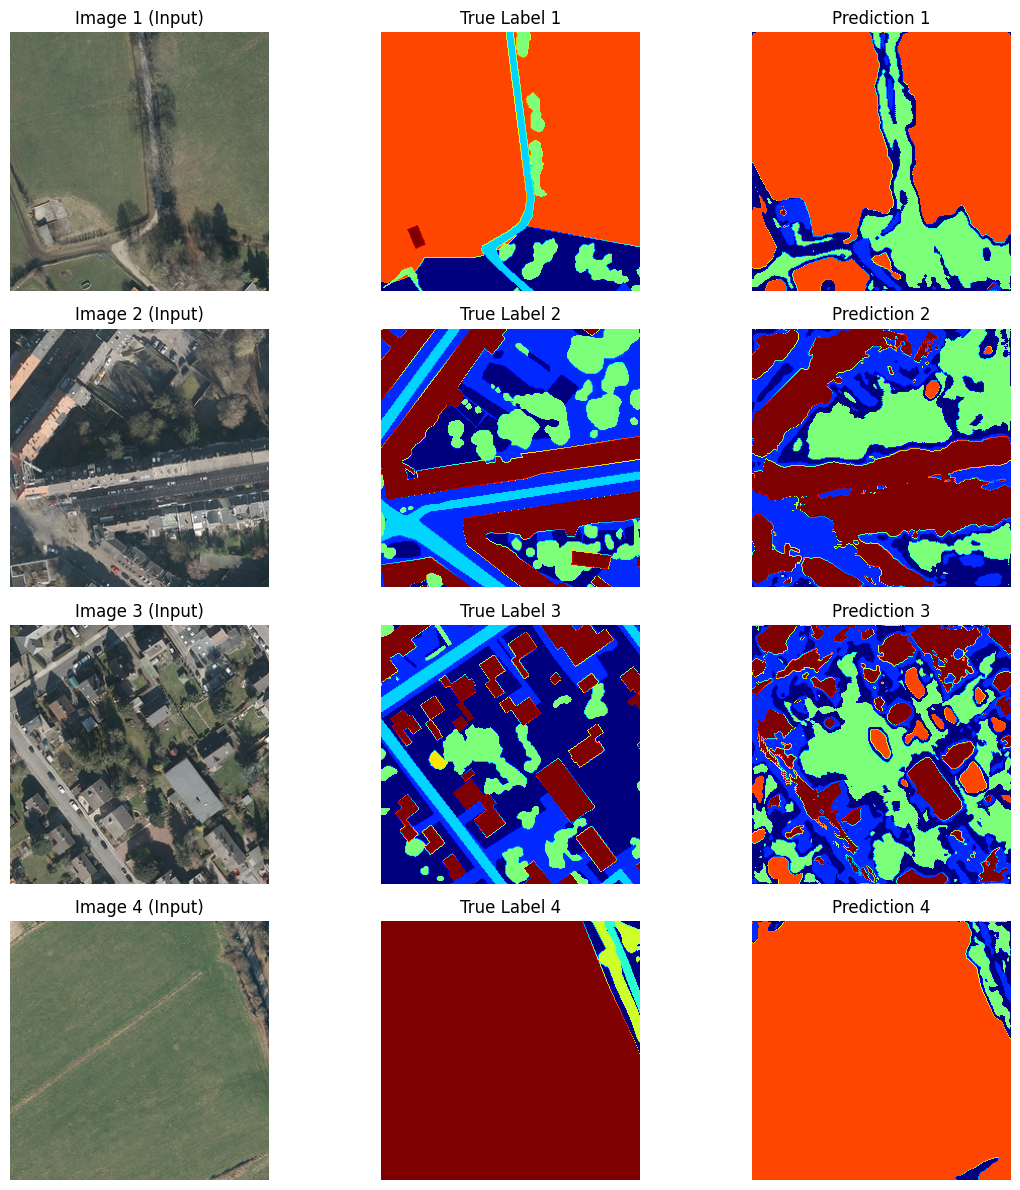

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Fonction pour afficher les prédictions
def plot_predictions(model, val_dataset, num_images=4):
    # Extraire une batch du dataset de validation
    for input_batch, target_batch in val_dataset.take(1):
        # Sélectionner aléatoirement num_images images dans la batch
        indices = np.random.choice(input_batch.shape[0], num_images, replace=False)
        
        # Créer une figure pour afficher les images
        plt.figure(figsize=(12, 12))

        for i, idx in enumerate(indices):
            # Extraire l'image et sa vérité de terrain
            image = input_batch[idx].numpy()  # Convertir en numpy array
            true_label = target_batch[idx].numpy()  # Convertir en numpy array
            
            # Prédiction du modèle (prédictions sous forme de probabilités)
            pred_prob = model.predict(np.expand_dims(image, axis=0))[0]  # Prédiction de l'image
            pred_class = np.argmax(pred_prob, axis=-1)  # Prendre la classe avec la probabilité maximale

            # Affichage de l'image d'entrée (X_val)
            plt.subplot(num_images, 3, 3*i+1)
            plt.imshow(image)
            plt.title(f"Image {i+1} (Input)")
            plt.axis('off')

            # Affichage de la vérité de terrain (Y_val)
            plt.subplot(num_images, 3, 3*i+2)
            plt.imshow(true_label.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"True Label {i+1}")
            plt.axis('off')

            # Affichage de la prédiction (Y_pred)
            plt.subplot(num_images, 3, 3*i+3)
            plt.imshow(pred_class.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"Prediction {i+1}")
            plt.axis('off')

        # Afficher le plot
        plt.tight_layout()
        plt.show()

# Exemple d'appel de la fonction (avec un jeu de données de validation et un modèle)
plot_predictions(model, val_dataset)

### original avec IoU metrics - Ne marche pas 

In [31]:
def iou_metric(y_true, y_pred):
    # Si vous faites de la segmentation binaire, vous pouvez arrondir les prédictions
    y_pred = K.round(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

In [27]:
import numpy as np

# Définir le ratio des données à utiliser
dataset_size_ratio = 0.005  # Par exemple, utiliser 50% des données

# Fonction pour charger et prétraiter les images
def load_and_preprocess_image(input_path, target_path, img_size=(256, 256)):
    # Charger l'image d'entrée (couleur)
    input_img = load_img(input_path, target_size=img_size)
    input_array = img_to_array(input_img) / 255.0  # Normalisation entre 0 et 1

    # Charger l'image cible (niveaux de gris)
    target_img = load_img(target_path, target_size=img_size, color_mode='grayscale')
    target_array = img_to_array(target_img)  # Normalisation entre 0 et 1

    # Assurer que target_array a la forme (256, 256, 1)
    target_array = target_array.reshape((256, 256, 1))  # Ajouter la dimension de canal

    return input_array, target_array

# Fonction pour obtenir les chemins des images
def get_image_paths(input_dir, target_dir, img_format="*.tif"):
    input_paths = sorted(tf.io.gfile.glob(os.path.join(input_dir, img_format)))
    target_paths = sorted(tf.io.gfile.glob(os.path.join(target_dir, img_format)))

    # Vérification des chemins
    for path in input_paths + target_paths:
        if not tf.io.gfile.exists(path):
            print(f"Chemin introuvable : {path}")

    return input_paths, target_paths

# Charger les chemins des images pour le jeu d'entraînement
train_input_images_dir = "data/processed_data/train/images"
train_target_images_dir = "data/processed_data/train/labels"
train_input_paths, train_target_paths = get_image_paths(train_input_images_dir, train_target_images_dir)

# Charger les chemins des images pour le jeu de validation
val_input_images_dir = "data/processed_data/val/images"
val_target_images_dir = "data/processed_data/val/labels"
val_input_paths, val_target_paths = get_image_paths(val_input_images_dir, val_target_images_dir)

# Limiter le nombre d'images en fonction du ratio défini
train_limit = int(len(train_input_paths) * dataset_size_ratio)
val_limit = int(len(val_input_paths) * dataset_size_ratio)

train_input_paths = train_input_paths[:train_limit]
train_target_paths = train_target_paths[:train_limit]

val_input_paths = val_input_paths[:val_limit]
val_target_paths = val_target_paths[:val_limit]

# Fonction génératrice pour créer les batches
def data_generator(input_paths, target_paths):
    for input_path, target_path in zip(input_paths, target_paths):
        try:
            input_array, target_array = load_and_preprocess_image(input_path, target_path)
            yield input_array, target_array
        except Exception as e:
            print(f"Erreur avec les fichiers : {input_path}, {target_path} - {e}")

# Dataset d'entraînement avec TensorFlow
train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(train_input_paths, train_target_paths)
)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Dataset de validation avec TensorFlow
val_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(val_input_paths, val_target_paths)
)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Affichage du nombre d'images d'entrée et cible pour chaque dataset
print(f"Nombre d'images d'entraînement - Entrée : {len(train_input_paths)}, Cible : {len(train_target_paths)}")
print(f"Nombre d'images de validation - Entrée : {len(val_input_paths)}, Cible : {len(val_target_paths)}")

Nombre d'images d'entraînement - Entrée : 177, Cible : 177
Nombre d'images de validation - Entrée : 29, Cible : 29


In [32]:
## Callbacks
es = EarlyStopping(patience = 4, restore_best_weights = True)
checkpoint_path = 'models/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}.h5'

cp = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)
def unet(input_shape, num_classes):
    inputs = Input(input_shape)
    # Encoder Block 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # Encoder Block 2
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # Encoder Block 3
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Encoder Block 4
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bridge
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(bridge)
    # Decoder Block 1
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat1 = Concatenate()([up1, conv4])
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # Decoder Block 2
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    # Decoder Block 3
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    # Decoder Block 4
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv8)
    # Model
    model = Model(inputs, outputs, name="U-Net")
    return model

model = unet((256, 256, 3),9)
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy', iou_metric])
history = model.fit(train_dataset, validation_data = val_dataset, batch_size = 32, epochs = 100, callbacks = [es,cp])

Epoch 1/100


2024-12-12 12:18:56.150986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      6/Unknown - 14s 2s/step - loss: 2.2676 - accuracy: 0.1909 - iou_metric: 0.1070   

2024-12-12 12:19:09.668359: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 566809887459385858
2024-12-12 12:19:09.668375: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 8903956609564657560
2024-12-12 12:19:09.668390: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11758384038986204065
2024-12-12 12:19:09.777454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 15s 2s/step - loss: 2.2676 - accuracy: 0.1909 - iou_metric: 0.1070 - val_loss: 1.9210 - val_accuracy: 0.2966 - val_iou_metric: 0.0000e+00
Epoch 2/100


2024-12-12 12:19:10.465868: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 5120658449776109610
2024-12-12 12:19:10.465881: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16748144125138967033
2024-12-12 12:19:10.465891: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15846358909402360732
2024-12-12 12:19:10.465896: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4002720322113299463


6/6 [==============================] - 14s 2s/step - loss: 1.8878 - accuracy: 0.2677 - iou_metric: 0.0000e+00 - val_loss: 1.7401 - val_accuracy: 0.2915 - val_iou_metric: 0.0000e+00
Epoch 3/100
6/6 [==============================] - 14s 2s/step - loss: 1.8261 - accuracy: 0.2505 - iou_metric: 0.0431 - val_loss: 1.7011 - val_accuracy: 0.3227 - val_iou_metric: 0.0000e+00
Epoch 4/100
6/6 [==============================] - 14s 2s/step - loss: 1.7375 - accuracy: 0.2717 - iou_metric: 0.0000e+00 - val_loss: 1.6810 - val_accuracy: 0.3226 - val_iou_metric: 7.9520e-07
Epoch 5/100
6/6 [==============================] - 14s 2s/step - loss: 1.7239 - accuracy: 0.2720 - iou_metric: 0.0148 - val_loss: 1.6559 - val_accuracy: 0.3237 - val_iou_metric: 0.0026
Epoch 6/100
6/6 [==============================] - 14s 2s/step - loss: 1.7043 - accuracy: 0.2724 - iou_metric: 0.0027 - val_loss: 1.6582 - val_accuracy: 0.3243 - val_iou_metric: 0.0000e+00
Epoch 7/100
6/6 [==============================] - 14s 2s/step 

1/1 [==============================] - 0s 11ms/step


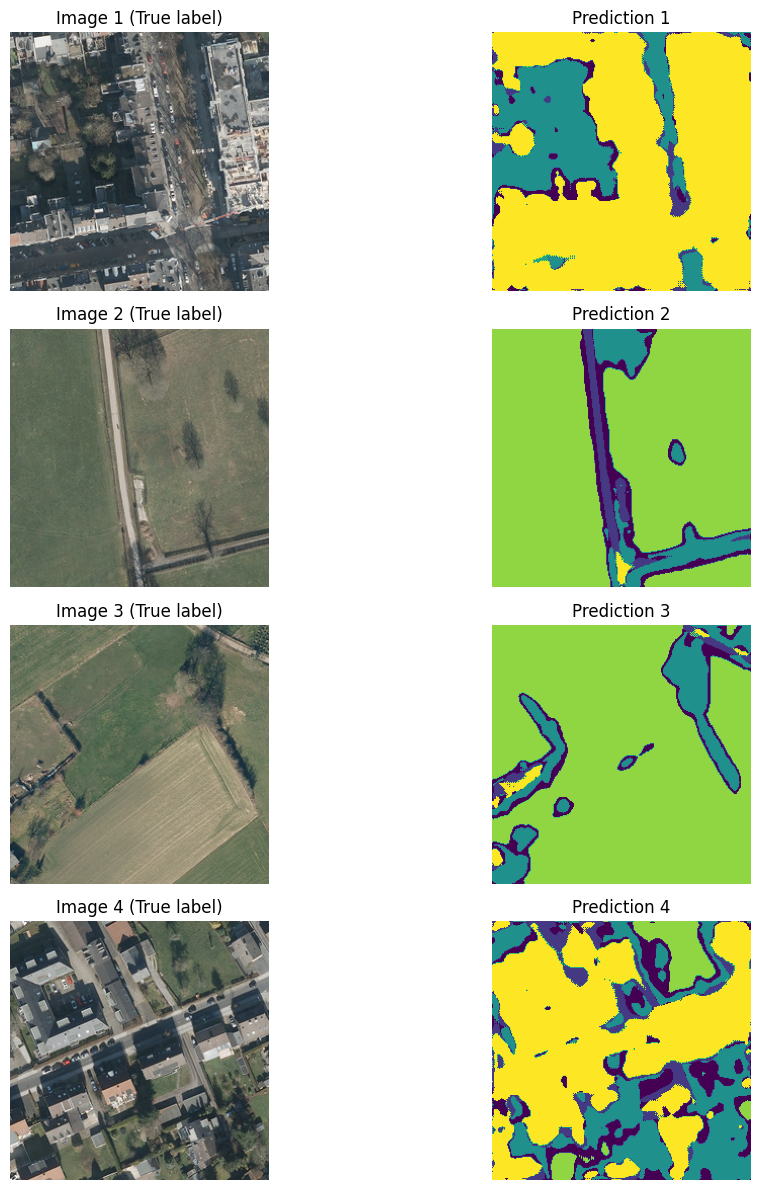

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Fonction pour afficher les prédictions
def plot_predictions(model, val_dataset, num_images=4):
    # Extraire une batch du dataset de validation
    for input_batch, target_batch in val_dataset.take(1):
        # Sélectionner aléatoirement num_images images dans la batch
        indices = np.random.choice(input_batch.shape[0], num_images, replace=False)
        
        # Créer une figure pour afficher les images
        plt.figure(figsize=(12, 12))

        for i, idx in enumerate(indices):
            # Extraire l'image et sa vérité de terrain
            image = input_batch[idx].numpy()  # Convertir en numpy array
            true_label = target_batch[idx].numpy()  # Convertir en numpy array
            
            # Prédiction du modèle (prédictions sous forme de probabilités)
            pred_prob = model.predict(np.expand_dims(image, axis=0))[0]  # Prédiction de l'image
            pred_class = np.argmax(pred_prob, axis=-1)  # Prendre la classe avec la probabilité maximale

            # Affichage de l'image originale
            plt.subplot(num_images, 2, 2*i+1)
            plt.imshow(image)
            plt.title(f"Image {i+1} (True label)")
            plt.axis('off')

            # Affichage de la prédiction (affichage de la classe prédite)
            plt.subplot(num_images, 2, 2*i+2)
            plt.imshow(pred_class.squeeze())  # Affichage en couleur (jet)
            plt.title(f"Prediction {i+1}")
            plt.axis('off')

        # Afficher le plot
        plt.tight_layout()
        plt.show()

# Exemple d'appel de la fonction (avec un jeu de données de validation et un modèle)
plot_predictions(model, val_dataset)

1/1 [==============================] - 0s 11ms/step


2024-12-12 12:41:24.014261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 11ms/step


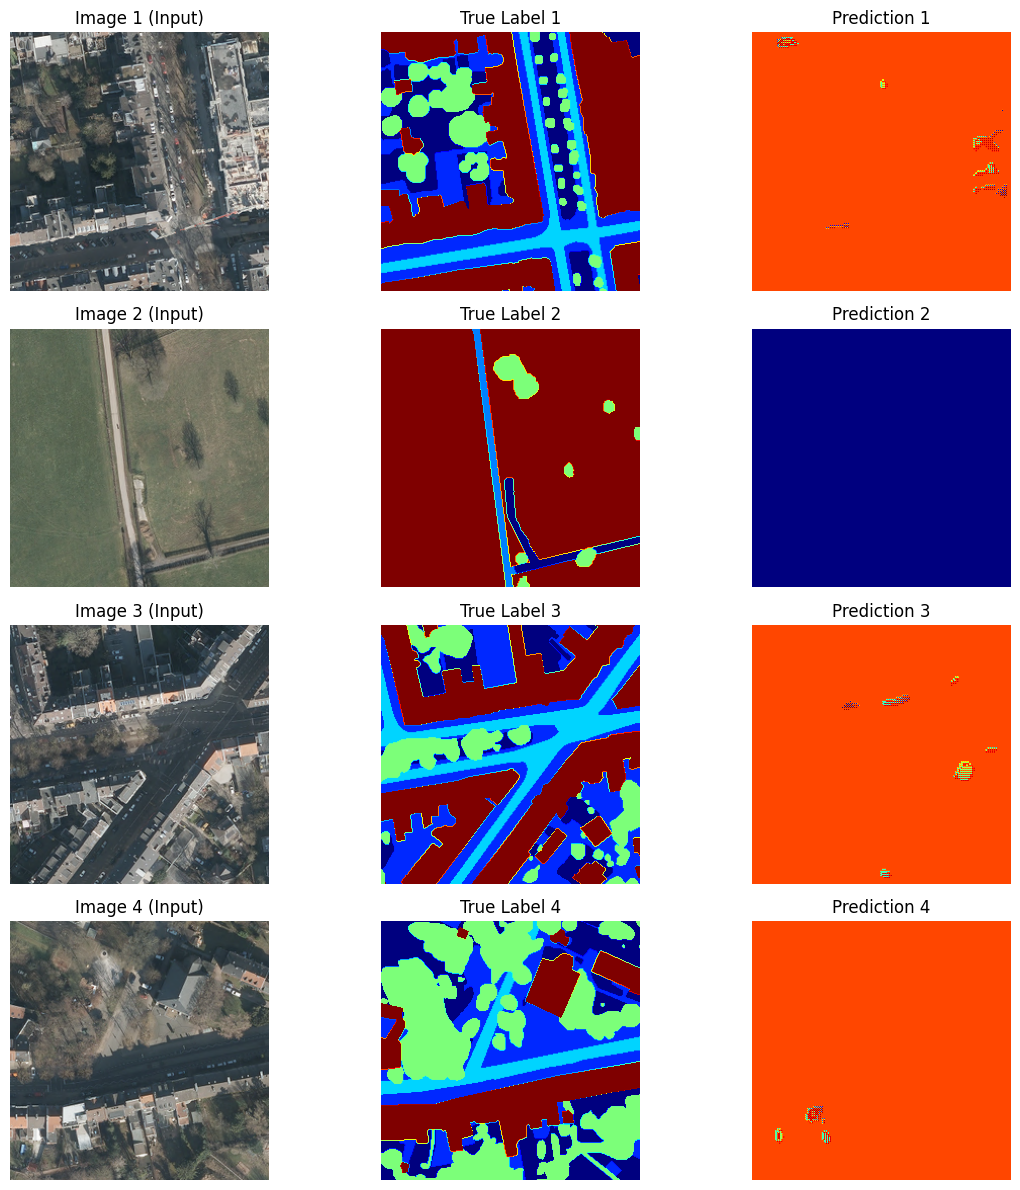

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Fonction pour afficher les prédictions
def plot_predictions(model, val_dataset, num_images=4):
    # Extraire une batch du dataset de validation
    for input_batch, target_batch in val_dataset.take(1):
        # Sélectionner aléatoirement num_images images dans la batch
        indices = np.random.choice(input_batch.shape[0], num_images, replace=False)
        
        # Créer une figure pour afficher les images
        plt.figure(figsize=(12, 12))

        for i, idx in enumerate(indices):
            # Extraire l'image et sa vérité de terrain
            image = input_batch[idx].numpy()  # Convertir en numpy array
            true_label = target_batch[idx].numpy()  # Convertir en numpy array
            
            # Prédiction du modèle (prédictions sous forme de probabilités)
            pred_prob = model.predict(np.expand_dims(image, axis=0))[0]  # Prédiction de l'image
            pred_class = np.argmax(pred_prob, axis=-1)  # Prendre la classe avec la probabilité maximale

            # Affichage de l'image d'entrée (X_val)
            plt.subplot(num_images, 3, 3*i+1)
            plt.imshow(image)
            plt.title(f"Image {i+1} (Input)")
            plt.axis('off')

            # Affichage de la vérité de terrain (Y_val)
            plt.subplot(num_images, 3, 3*i+2)
            plt.imshow(true_label.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"True Label {i+1}")
            plt.axis('off')

            # Affichage de la prédiction (Y_pred)
            plt.subplot(num_images, 3, 3*i+3)
            plt.imshow(pred_class.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"Prediction {i+1}")
            plt.axis('off')

        # Afficher le plot
        plt.tight_layout()
        plt.show()

# Exemple d'appel de la fonction (avec un jeu de données de validation et un modèle)
plot_predictions(model, val_dataset)

### Optimizer adam learning rate 

In [41]:
import numpy as np

# Définir le ratio des données à utiliser
dataset_size_ratio = 0.005  # Par exemple, utiliser 50% des données

# Fonction pour charger et prétraiter les images
def load_and_preprocess_image(input_path, target_path, img_size=(256, 256)):
    # Charger l'image d'entrée (couleur)
    input_img = load_img(input_path, target_size=img_size)
    input_array = img_to_array(input_img) / 255.0  # Normalisation entre 0 et 1

    # Charger l'image cible (niveaux de gris)
    target_img = load_img(target_path, target_size=img_size, color_mode='grayscale')
    target_array = img_to_array(target_img)  # Normalisation entre 0 et 1

    # Assurer que target_array a la forme (256, 256, 1)
    target_array = target_array.reshape((256, 256, 1))  # Ajouter la dimension de canal

    return input_array, target_array

# Fonction pour obtenir les chemins des images
def get_image_paths(input_dir, target_dir, img_format="*.tif"):
    input_paths = sorted(tf.io.gfile.glob(os.path.join(input_dir, img_format)))
    target_paths = sorted(tf.io.gfile.glob(os.path.join(target_dir, img_format)))

    # Vérification des chemins
    for path in input_paths + target_paths:
        if not tf.io.gfile.exists(path):
            print(f"Chemin introuvable : {path}")

    return input_paths, target_paths

# Charger les chemins des images pour le jeu d'entraînement
train_input_images_dir = "data/processed_data/train/images"
train_target_images_dir = "data/processed_data/train/labels"
train_input_paths, train_target_paths = get_image_paths(train_input_images_dir, train_target_images_dir)

# Charger les chemins des images pour le jeu de validation
val_input_images_dir = "data/processed_data/val/images"
val_target_images_dir = "data/processed_data/val/labels"
val_input_paths, val_target_paths = get_image_paths(val_input_images_dir, val_target_images_dir)

# Limiter le nombre d'images en fonction du ratio défini
train_limit = int(len(train_input_paths) * dataset_size_ratio)
val_limit = int(len(val_input_paths) * dataset_size_ratio)

train_input_paths = train_input_paths[:train_limit]
train_target_paths = train_target_paths[:train_limit]

val_input_paths = val_input_paths[:val_limit]
val_target_paths = val_target_paths[:val_limit]

# Fonction génératrice pour créer les batches
def data_generator(input_paths, target_paths):
    for input_path, target_path in zip(input_paths, target_paths):
        try:
            input_array, target_array = load_and_preprocess_image(input_path, target_path)
            yield input_array, target_array
        except Exception as e:
            print(f"Erreur avec les fichiers : {input_path}, {target_path} - {e}")

# Dataset d'entraînement avec TensorFlow
train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(train_input_paths, train_target_paths)
)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Dataset de validation avec TensorFlow
val_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(val_input_paths, val_target_paths)
)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Affichage du nombre d'images d'entrée et cible pour chaque dataset
print(f"Nombre d'images d'entraînement - Entrée : {len(train_input_paths)}, Cible : {len(train_target_paths)}")
print(f"Nombre d'images de validation - Entrée : {len(val_input_paths)}, Cible : {len(val_target_paths)}")

Nombre d'images d'entraînement - Entrée : 177, Cible : 177
Nombre d'images de validation - Entrée : 29, Cible : 29


In [42]:
## Callbacks
es = EarlyStopping(patience = 4, restore_best_weights = True)
checkpoint_path = 'models/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}.h5'

cp = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)
def unet(input_shape, num_classes):
    inputs = Input(input_shape)
    # Encoder Block 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # Encoder Block 2
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # Encoder Block 3
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Encoder Block 4
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bridge
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(bridge)
    # Decoder Block 1
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat1 = Concatenate()([up1, conv4])
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # Decoder Block 2
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    # Decoder Block 3
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    # Decoder Block 4
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv8)
    # Model
    model = Model(inputs, outputs, name="U-Net")
    return model

model = unet((256, 256, 3),9)
model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy', iou_metric])
history = model.fit(train_dataset, validation_data = val_dataset, batch_size = 32, epochs = 100, callbacks = [es,cp])

Epoch 1/100


2024-12-12 12:44:17.779270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      6/Unknown - 14s 2s/step - loss: 3793008.5000 - accuracy: 0.1300 - iou_metric: 3.9924

2024-12-12 12:44:31.050476: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4736452183684247546
2024-12-12 12:44:31.050491: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4235120653256499336
2024-12-12 12:44:31.050495: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11758384038986204065
2024-12-12 12:44:31.050508: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9264436764061744543
2024-12-12 12:44:31.050513: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1929875478821717903
2024-12-12 12:44:31.050518: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 8903956609564657560
2024-12-12 12:44:31.163660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114]

6/6 [==============================] - 15s 2s/step - loss: 3793008.5000 - accuracy: 0.1300 - iou_metric: 3.9924 - val_loss: 353951.8750 - val_accuracy: 0.2052 - val_iou_metric: 5.2934
Epoch 2/100
6/6 [==============================] - 15s 2s/step - loss: 530154.5000 - accuracy: 0.1780 - iou_metric: 4.2902 - val_loss: 2.1564 - val_accuracy: 0.0974 - val_iou_metric: 1.2685e-04
Epoch 3/100
6/6 [==============================] - 14s 2s/step - loss: 298.4685 - accuracy: 0.1932 - iou_metric: 0.8003 - val_loss: 4.3615 - val_accuracy: 0.0974 - val_iou_metric: 0.0011
Epoch 4/100
6/6 [==============================] - 16s 3s/step - loss: 1823272.8750 - accuracy: 0.2023 - iou_metric: 1.6298 - val_loss: 1602.2230 - val_accuracy: 0.0984 - val_iou_metric: 0.1279
Epoch 5/100
6/6 [==============================] - 14s 2s/step - loss: 430.0918 - accuracy: 0.1916 - iou_metric: 0.0226 - val_loss: 2.0740 - val_accuracy: 0.0974 - val_iou_metric: 1.0060e-04
Epoch 6/100
6/6 [==============================] -

1/1 [==============================] - 0s 13ms/step


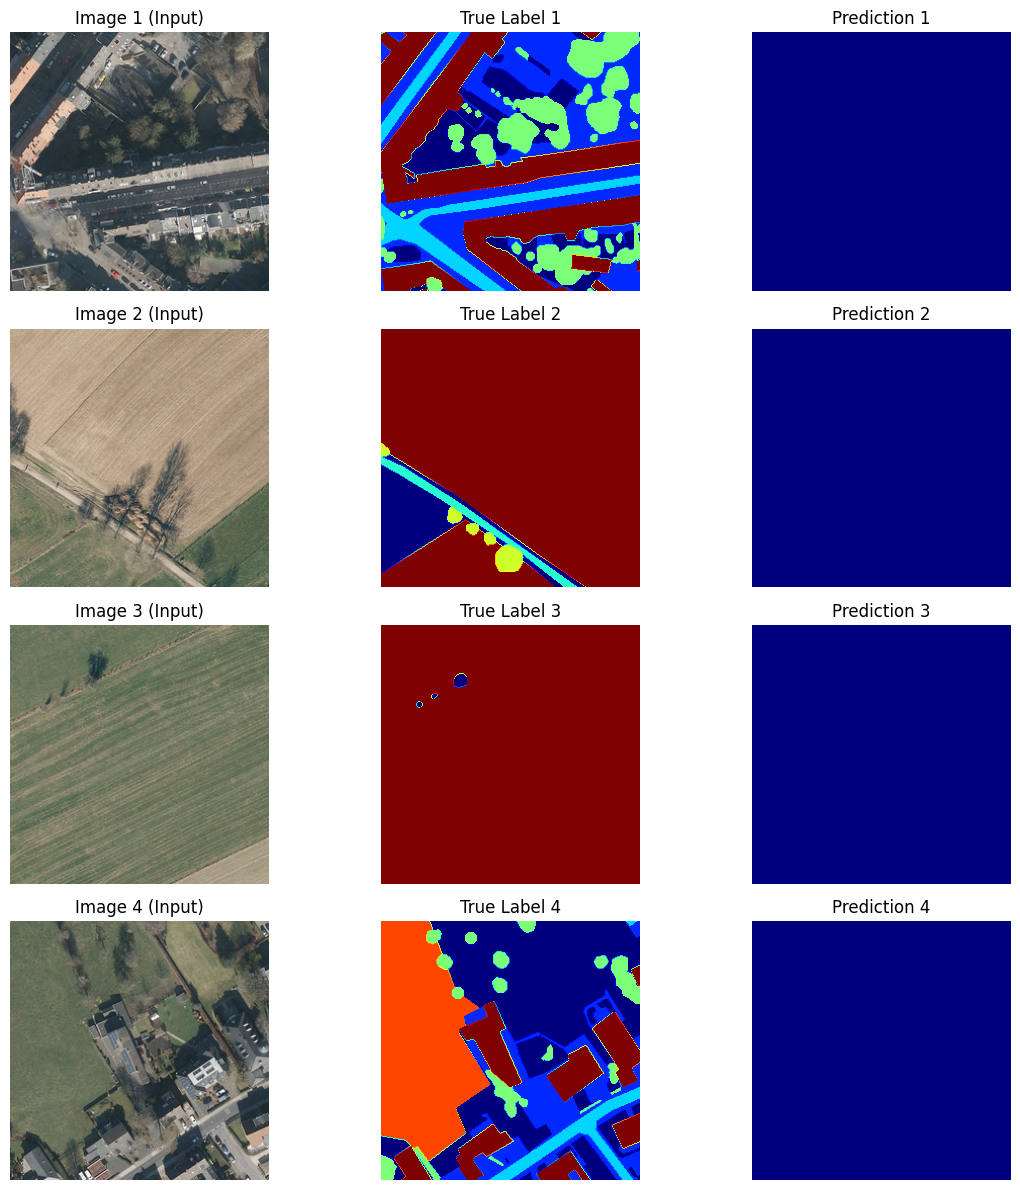

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Fonction pour afficher les prédictions
def plot_predictions(model, val_dataset, num_images=4):
    # Extraire une batch du dataset de validation
    for input_batch, target_batch in val_dataset.take(1):
        # Sélectionner aléatoirement num_images images dans la batch
        indices = np.random.choice(input_batch.shape[0], num_images, replace=False)
        
        # Créer une figure pour afficher les images
        plt.figure(figsize=(12, 12))

        for i, idx in enumerate(indices):
            # Extraire l'image et sa vérité de terrain
            image = input_batch[idx].numpy()  # Convertir en numpy array
            true_label = target_batch[idx].numpy()  # Convertir en numpy array
            
            # Prédiction du modèle (prédictions sous forme de probabilités)
            pred_prob = model.predict(np.expand_dims(image, axis=0))[0]  # Prédiction de l'image
            pred_class = np.argmax(pred_prob, axis=-1)  # Prendre la classe avec la probabilité maximale

            # Affichage de l'image d'entrée (X_val)
            plt.subplot(num_images, 3, 3*i+1)
            plt.imshow(image)
            plt.title(f"Image {i+1} (Input)")
            plt.axis('off')

            # Affichage de la vérité de terrain (Y_val)
            plt.subplot(num_images, 3, 3*i+2)
            plt.imshow(true_label.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"True Label {i+1}")
            plt.axis('off')

            # Affichage de la prédiction (Y_pred)
            plt.subplot(num_images, 3, 3*i+3)
            plt.imshow(pred_class.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"Prediction {i+1}")
            plt.axis('off')

        # Afficher le plot
        plt.tight_layout()
        plt.show()

# Exemple d'appel de la fonction (avec un jeu de données de validation et un modèle)
plot_predictions(model, val_dataset)

### Res-UNET

In [54]:
import numpy as np

# Définir le ratio des données à utiliser
dataset_size_ratio = 0.005  # Par exemple, utiliser 50% des données

# Fonction pour charger et prétraiter les images
def load_and_preprocess_image(input_path, target_path, img_size=(256, 256)):
    # Charger l'image d'entrée (couleur)
    input_img = load_img(input_path, target_size=img_size)
    input_array = img_to_array(input_img) / 255.0  # Normalisation entre 0 et 1

    # Charger l'image cible (niveaux de gris)
    target_img = load_img(target_path, target_size=img_size, color_mode='grayscale')
    target_array = img_to_array(target_img)  # Normalisation entre 0 et 1

    # Assurer que target_array a la forme (256, 256, 1)
    target_array = target_array.reshape((256, 256, 1))  # Ajouter la dimension de canal

    return input_array, target_array

# Fonction pour obtenir les chemins des images
def get_image_paths(input_dir, target_dir, img_format="*.tif"):
    input_paths = sorted(tf.io.gfile.glob(os.path.join(input_dir, img_format)))
    target_paths = sorted(tf.io.gfile.glob(os.path.join(target_dir, img_format)))

    # Vérification des chemins
    for path in input_paths + target_paths:
        if not tf.io.gfile.exists(path):
            print(f"Chemin introuvable : {path}")

    return input_paths, target_paths

# Charger les chemins des images pour le jeu d'entraînement
train_input_images_dir = "data/processed_data/train/images"
train_target_images_dir = "data/processed_data/train/labels"
train_input_paths, train_target_paths = get_image_paths(train_input_images_dir, train_target_images_dir)

# Charger les chemins des images pour le jeu de validation
val_input_images_dir = "data/processed_data/val/images"
val_target_images_dir = "data/processed_data/val/labels"
val_input_paths, val_target_paths = get_image_paths(val_input_images_dir, val_target_images_dir)

# Limiter le nombre d'images en fonction du ratio défini
train_limit = int(len(train_input_paths) * dataset_size_ratio)
val_limit = int(len(val_input_paths) * dataset_size_ratio)

train_input_paths = train_input_paths[:train_limit]
train_target_paths = train_target_paths[:train_limit]

val_input_paths = val_input_paths[:val_limit]
val_target_paths = val_target_paths[:val_limit]

# Fonction génératrice pour créer les batches
def data_generator(input_paths, target_paths):
    for input_path, target_path in zip(input_paths, target_paths):
        try:
            input_array, target_array = load_and_preprocess_image(input_path, target_path)
            yield input_array, target_array
        except Exception as e:
            print(f"Erreur avec les fichiers : {input_path}, {target_path} - {e}")

# Dataset d'entraînement avec TensorFlow
train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(train_input_paths, train_target_paths)
)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Dataset de validation avec TensorFlow
val_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(val_input_paths, val_target_paths)
)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Affichage du nombre d'images d'entrée et cible pour chaque dataset
print(f"Nombre d'images d'entraînement - Entrée : {len(train_input_paths)}, Cible : {len(train_target_paths)}")
print(f"Nombre d'images de validation - Entrée : {len(val_input_paths)}, Cible : {len(val_target_paths)}")

Nombre d'images d'entraînement - Entrée : 177, Cible : 177
Nombre d'images de validation - Entrée : 29, Cible : 29


In [58]:
def residual_block(x, filters):
    # Shortcut to match filters if needed
    shortcut = Conv2D(filters, (1, 1), padding='same')(x) if x.shape[-1] != filters else x
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = Add()([shortcut, x])  # Combine shortcut and convolutional path
    return x
def resunet(input_shape, num_classes):
    inputs = Input(input_shape)
    # Adjust input channels to match the first residual block
    inputs_adjusted = Conv2D(64, (1, 1), padding='same')(inputs)
    # Encoder Block 1
    conv1 = residual_block(inputs_adjusted, 64)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # Encoder Block 2
    conv2 = residual_block(pool1, 128)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # Encoder Block 3
    conv3 = residual_block(pool2, 256)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Encoder Block 4
    conv4 = residual_block(pool3, 512)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bridge
    bridge = residual_block(pool4, 1024)
    # Decoder Block 1
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat1 = Concatenate()([up1, conv4])
    conv5 = residual_block(concat1, 512)
    # Decoder Block 2
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = residual_block(concat2, 256)
    # Decoder Block 3
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = residual_block(concat3, 128)
    # Decoder Block 4
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = residual_block(concat4, 64)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv8)
    # Model
    model = Model(inputs, outputs, name="Res-U-Net")
    return model

model = resunet((256, 256, 3),9)
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, validation_data = val_dataset, batch_size = 32, epochs = 100, callbacks = [es,cp])

Epoch 1/100


2024-12-12 15:36:44.303877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      6/Unknown - 18s 3s/step - loss: 1.9826 - accuracy: 0.2415

2024-12-12 15:37:01.755685: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 12079045578406857469
2024-12-12 15:37:01.755699: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1426786114789915477
2024-12-12 15:37:01.755704: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 2175642257791477599
2024-12-12 15:37:01.889886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-12 15:37:02.745729: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4350007951263873499
2024-12-12 15:37:02.745743: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10844431209334807237
2024-12-12 15:37:02.745748: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous 

6/6 [==============================] - 19s 3s/step - loss: 1.9826 - accuracy: 0.2415 - val_loss: 1.8180 - val_accuracy: 0.3591
Epoch 2/100
6/6 [==============================] - 18s 3s/step - loss: 1.8502 - accuracy: 0.3078 - val_loss: 1.6673 - val_accuracy: 0.3267
Epoch 3/100
6/6 [==============================] - 18s 3s/step - loss: 2.0479 - accuracy: 0.2567 - val_loss: 1.7413 - val_accuracy: 0.3658
Epoch 4/100
6/6 [==============================] - 18s 3s/step - loss: 1.7684 - accuracy: 0.2296 - val_loss: 1.7265 - val_accuracy: 0.2482
Epoch 5/100
6/6 [==============================] - 18s 3s/step - loss: 1.7314 - accuracy: 0.2746 - val_loss: 1.5910 - val_accuracy: 0.3627
Epoch 6/100
6/6 [==============================] - 18s 3s/step - loss: 1.6585 - accuracy: 0.3102 - val_loss: 1.5342 - val_accuracy: 0.3875
Epoch 7/100
6/6 [==============================] - 18s 3s/step - loss: 1.7028 - accuracy: 0.2791 - val_loss: 1.6601 - val_accuracy: 0.3954
Epoch 8/100
6/6 [======================

1/1 [==============================] - 0s 12ms/step


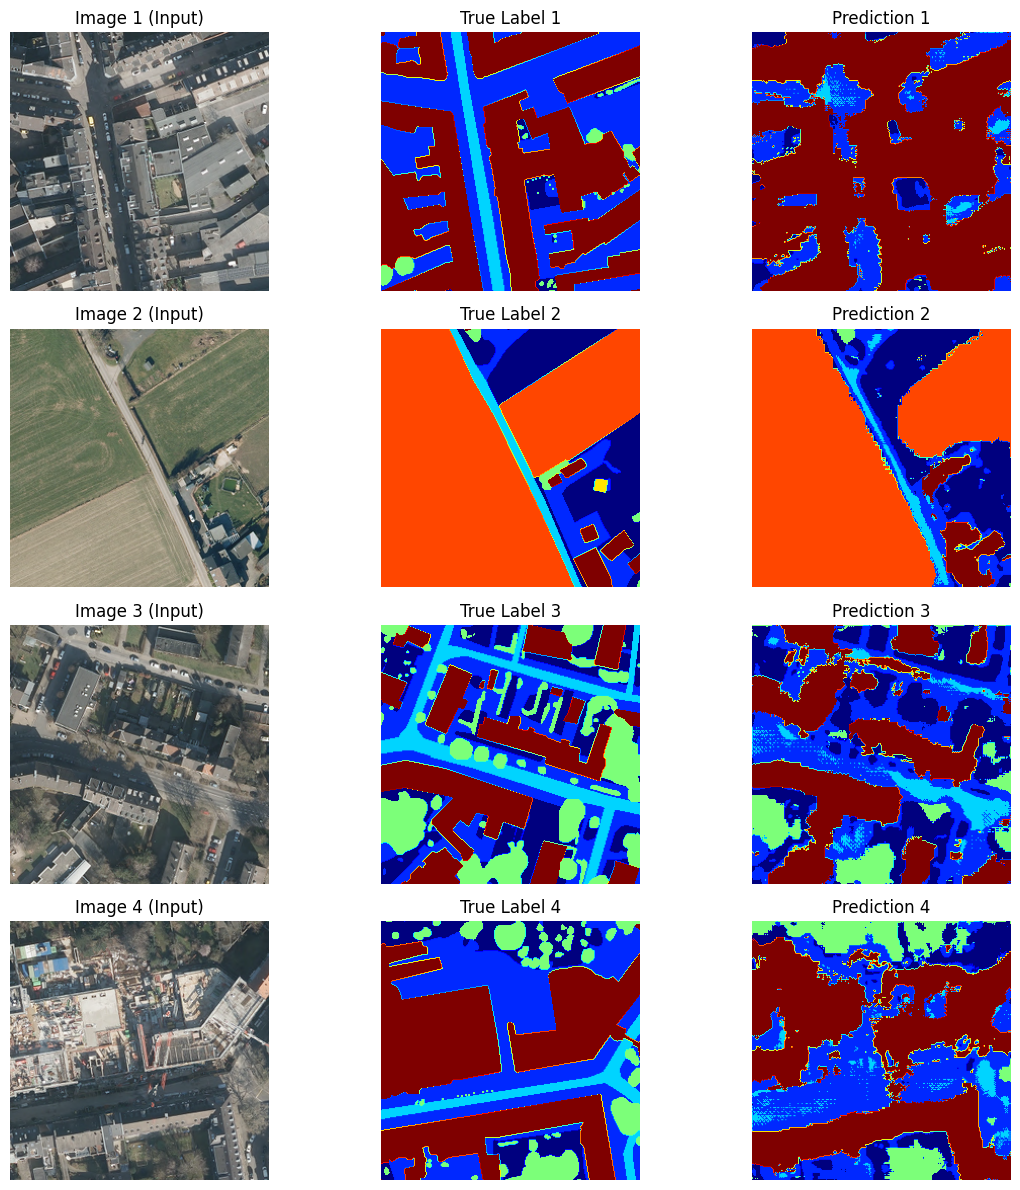

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Fonction pour afficher les prédictions
def plot_predictions(model, val_dataset, num_images=4):
    # Extraire une batch du dataset de validation
    for input_batch, target_batch in val_dataset.take(1):
        # Sélectionner aléatoirement num_images images dans la batch
        indices = np.random.choice(input_batch.shape[0], num_images, replace=False)
        
        # Créer une figure pour afficher les images
        plt.figure(figsize=(12, 12))

        for i, idx in enumerate(indices):
            # Extraire l'image et sa vérité de terrain
            image = input_batch[idx].numpy()  # Convertir en numpy array
            true_label = target_batch[idx].numpy()  # Convertir en numpy array
            
            # Prédiction du modèle (prédictions sous forme de probabilités)
            pred_prob = model.predict(np.expand_dims(image, axis=0))[0]  # Prédiction de l'image
            pred_class = np.argmax(pred_prob, axis=-1)  # Prendre la classe avec la probabilité maximale

            # Affichage de l'image d'entrée (X_val)
            plt.subplot(num_images, 3, 3*i+1)
            plt.imshow(image)
            plt.title(f"Image {i+1} (Input)")
            plt.axis('off')

            # Affichage de la vérité de terrain (Y_val)
            plt.subplot(num_images, 3, 3*i+2)
            plt.imshow(true_label.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"True Label {i+1}")
            plt.axis('off')

            # Affichage de la prédiction (Y_pred)
            plt.subplot(num_images, 3, 3*i+3)
            plt.imshow(pred_class.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"Prediction {i+1}")
            plt.axis('off')

        # Afficher le plot
        plt.tight_layout()
        plt.show()

# Exemple d'appel de la fonction (avec un jeu de données de validation et un modèle)
plot_predictions(model, val_dataset)

### 👑👑👑👑👑👑👑👑👑👑👑 Dice loss + RES Unet 👑👑👑👑👑👑👑👑👑👑👑👑👑👑👑👑

In [ ]:
# Paramètres de sauvegarde du modèle 

## Call
id = "C.3"
taille_data = "partial"
attribut = "Batch_64_Dice_loss_RESUNET"
dossier = "models/" + id + " - " + attribut + "_" + taille_data


es = EarlyStopping(patience = 4, restore_best_weights = True)
checkpoint_path =  dossier + '/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}.h5'

cp = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)


In [ ]:
# Définir le ratio des données à utiliser
dataset_size_ratio = 0.005  # Par exemple, utiliser 50% des données

# Fonction pour charger et prétraiter les images
def load_and_preprocess_image(input_path, target_path, img_size=(256, 256)):
    # Charger l'image d'entrée (couleur)
    input_img = load_img(input_path, target_size=img_size)
    input_array = img_to_array(input_img) / 255.0  # Normalisation entre 0 et 1

    # Charger l'image cible (niveaux de gris)
    target_img = load_img(target_path, target_size=img_size, color_mode='grayscale')
    target_array = img_to_array(target_img)  # Normalisation entre 0 et 1

    # Assurer que target_array a la forme (256, 256, 1)
    target_array = target_array.reshape((256, 256, 1))  # Ajouter la dimension de canal

    return input_array, target_array

# Fonction pour obtenir les chemins des images
def get_image_paths(input_dir, target_dir, img_format="*.tif"):
    input_paths = sorted(tf.io.gfile.glob(os.path.join(input_dir, img_format)))
    target_paths = sorted(tf.io.gfile.glob(os.path.join(target_dir, img_format)))

    # Vérification des chemins
    for path in input_paths + target_paths:
        if not tf.io.gfile.exists(path):
            print(f"Chemin introuvable : {path}")

    return input_paths, target_paths

# Charger les chemins des images pour le jeu d'entraînement
train_input_images_dir = "data/processed_data/train/images"
train_target_images_dir = "data/processed_data/train/labels"
train_input_paths, train_target_paths = get_image_paths(train_input_images_dir, train_target_images_dir)

# Charger les chemins des images pour le jeu de validation
val_input_images_dir = "data/processed_data/val/images"
val_target_images_dir = "data/processed_data/val/labels"
val_input_paths, val_target_paths = get_image_paths(val_input_images_dir, val_target_images_dir)

# Limiter le nombre d'images en fonction du ratio défini
train_limit = int(len(train_input_paths) * dataset_size_ratio)
val_limit = int(len(val_input_paths) * dataset_size_ratio)

train_input_paths = train_input_paths[:train_limit]
train_target_paths = train_target_paths[:train_limit]

val_input_paths = val_input_paths[:val_limit]
val_target_paths = val_target_paths[:val_limit]

# Fonction génératrice pour créer les batches
def data_generator(input_paths, target_paths):
    for input_path, target_path in zip(input_paths, target_paths):
        try:
            input_array, target_array = load_and_preprocess_image(input_path, target_path)
            yield input_array, target_array
        except Exception as e:
            print(f"Erreur avec les fichiers : {input_path}, {target_path} - {e}")

# Dataset d'entraînement avec TensorFlow
train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(train_input_paths, train_target_paths)
)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(64).prefetch(tf.data.AUTOTUNE)

# Dataset de validation avec TensorFlow
val_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(val_input_paths, val_target_paths)
)
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

# Affichage du nombre d'images d'entrée et cible pour chaque dataset
print(f"Nombre d'images d'entraînement - Entrée : {len(train_input_paths)}, Cible : {len(train_target_paths)}")
print(f"Nombre d'images de validation - Entrée : {len(val_input_paths)}, Cible : {len(val_target_paths)}")

In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Dice loss for multi-class segmentation.
    :param y_true: Ground truth, one-hot encoded or sparse categorical
    :param y_pred: Predicted logits (after softmax)
    :param smooth: Smoothing factor to avoid division by zero
    :return: Dice loss value
    """
    # Si y_true est en format sparse, on applique one-hot
    num_classes = tf.shape(y_pred)[-1]
    if tf.rank(y_true) == tf.rank(y_pred) - 1:
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 1e-6, 1.0)  # éviter des prédictions égales à 0
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)  # Dice Loss

def combined_loss(y_true, y_pred):
    ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return ce_loss + d_loss


In [80]:
def residual_block(x, filters):
    # Shortcut to match filters if needed
    shortcut = Conv2D(filters, (1, 1), padding='same')(x) if x.shape[-1] != filters else x
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = Add()([shortcut, x])  # Combine shortcut and convolutional path
    return x
def resunet(input_shape, num_classes):
    inputs = Input(input_shape)
    # Adjust input channels to match the first residual block
    inputs_adjusted = Conv2D(64, (1, 1), padding='same')(inputs)
    # Encoder Block 1
    conv1 = residual_block(inputs_adjusted, 64)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # Encoder Block 2
    conv2 = residual_block(pool1, 128)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # Encoder Block 3
    conv3 = residual_block(pool2, 256)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Encoder Block 4
    conv4 = residual_block(pool3, 512)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bridge
    bridge = residual_block(pool4, 1024)
    # Decoder Block 1
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat1 = Concatenate()([up1, conv4])
    conv5 = residual_block(concat1, 512)
    # Decoder Block 2
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = residual_block(concat2, 256)
    # Decoder Block 3
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = residual_block(concat3, 128)
    # Decoder Block 4
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = residual_block(concat4, 64)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv8)
    # Model
    model = Model(inputs, outputs, name="Res-U-Net")
    return model

model = resunet((256, 256, 3),9)

model.load_weights("models/C.2 - Dice_loss_RESUNET_partial/model_epoch_39_val_accuracy_0.70.h5")


1/1 [==============================] - 0s 11ms/step


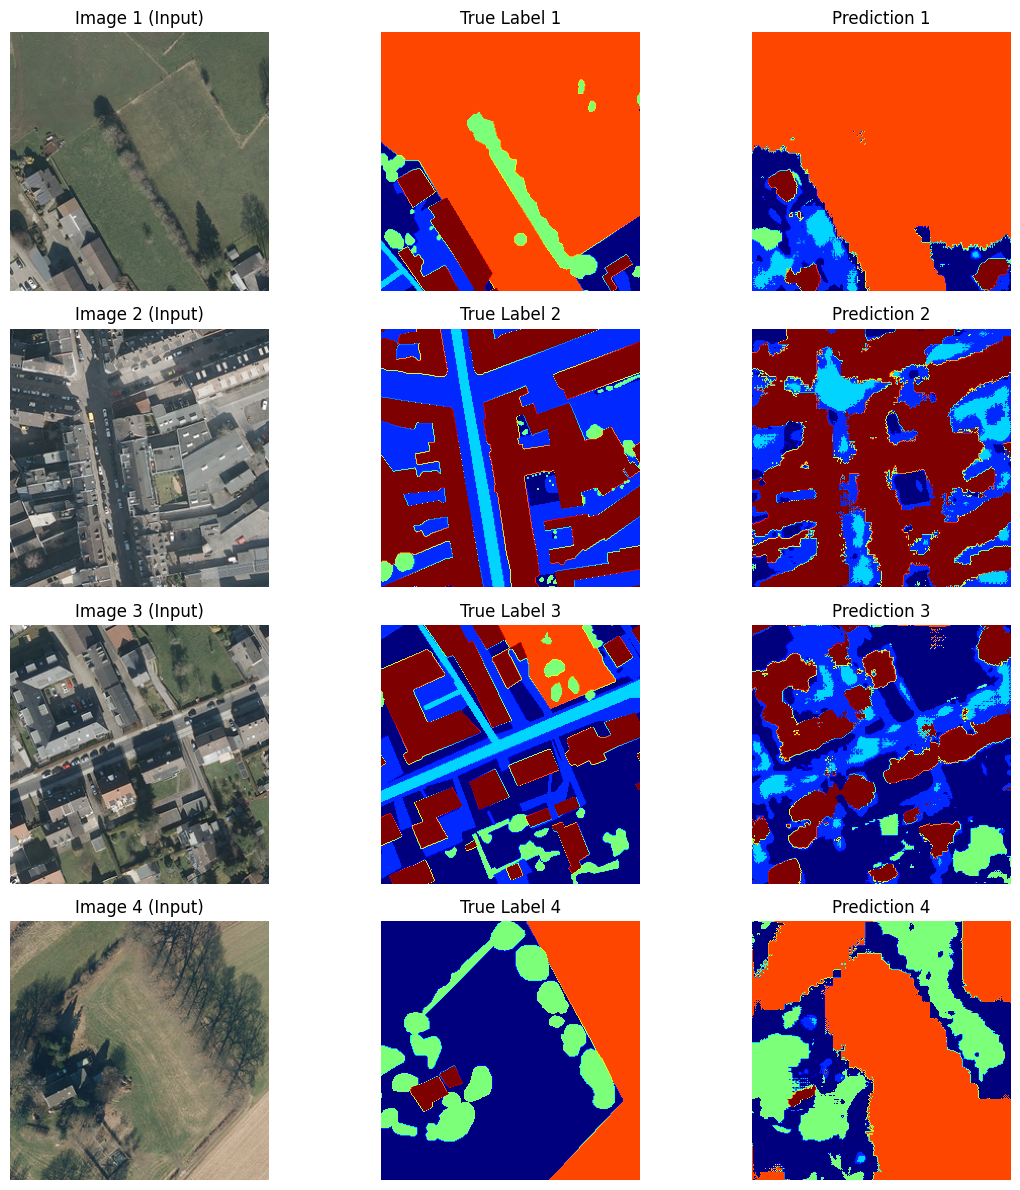

In [87]:
# Fonction pour afficher les prédictions
def plot_predictions(model, val_dataset, num_images=4):
    # Extraire une batch du dataset de validation
    for input_batch, target_batch in val_dataset.take(1):
        # Sélectionner aléatoirement num_images images dans la batch
        indices = np.random.choice(input_batch.shape[0], num_images, replace=False)
        
        # Créer une figure pour afficher les images
        plt.figure(figsize=(12, 12))

        for i, idx in enumerate(indices):
            # Extraire l'image et sa vérité de terrain
            image = input_batch[idx].numpy()  # Convertir en numpy array
            true_label = target_batch[idx].numpy()  # Convertir en numpy array
            
            # Prédiction du modèle (prédictions sous forme de probabilités)
            pred_prob = model.predict(np.expand_dims(image, axis=0))[0]  # Prédiction de l'image
            pred_class = np.argmax(pred_prob, axis=-1)  # Prendre la classe avec la probabilité maximale

            # Affichage de l'image d'entrée (X_val)
            plt.subplot(num_images, 3, 3*i+1)
            plt.imshow(image)
            plt.title(f"Image {i+1} (Input)")
            plt.axis('off')

            # Affichage de la vérité de terrain (Y_val)
            plt.subplot(num_images, 3, 3*i+2)
            plt.imshow(true_label.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"True Label {i+1}")
            plt.axis('off')

            # Affichage de la prédiction (Y_pred)
            plt.subplot(num_images, 3, 3*i+3)
            plt.imshow(pred_class.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"Prediction {i+1}")
            plt.axis('off')

        # Afficher le plot
        plt.tight_layout()
        plt.show()

# Exemple d'appel de la fonction (avec un jeu de données de validation et un modèle)
plot_predictions(model, val_dataset)

### BATCH 64 Dice loss + RES Unet 

In [75]:
# Paramètres de sauvegarde du modèle 

## Call
id = "C.3"
taille_data = "partial"
attribut = "Batch_64_Dice_loss_RESUNET"
dossier = "models/" + id + " - " + attribut + "_" + taille_data


es = EarlyStopping(patience = 4, restore_best_weights = True)
checkpoint_path =  dossier + '/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}.h5'

cp = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)


In [76]:
# Définir le ratio des données à utiliser
dataset_size_ratio = 0.005  # Par exemple, utiliser 50% des données

# Fonction pour charger et prétraiter les images
def load_and_preprocess_image(input_path, target_path, img_size=(256, 256)):
    # Charger l'image d'entrée (couleur)
    input_img = load_img(input_path, target_size=img_size)
    input_array = img_to_array(input_img) / 255.0  # Normalisation entre 0 et 1

    # Charger l'image cible (niveaux de gris)
    target_img = load_img(target_path, target_size=img_size, color_mode='grayscale')
    target_array = img_to_array(target_img)  # Normalisation entre 0 et 1

    # Assurer que target_array a la forme (256, 256, 1)
    target_array = target_array.reshape((256, 256, 1))  # Ajouter la dimension de canal

    return input_array, target_array

# Fonction pour obtenir les chemins des images
def get_image_paths(input_dir, target_dir, img_format="*.tif"):
    input_paths = sorted(tf.io.gfile.glob(os.path.join(input_dir, img_format)))
    target_paths = sorted(tf.io.gfile.glob(os.path.join(target_dir, img_format)))

    # Vérification des chemins
    for path in input_paths + target_paths:
        if not tf.io.gfile.exists(path):
            print(f"Chemin introuvable : {path}")

    return input_paths, target_paths

# Charger les chemins des images pour le jeu d'entraînement
train_input_images_dir = "data/processed_data/train/images"
train_target_images_dir = "data/processed_data/train/labels"
train_input_paths, train_target_paths = get_image_paths(train_input_images_dir, train_target_images_dir)

# Charger les chemins des images pour le jeu de validation
val_input_images_dir = "data/processed_data/val/images"
val_target_images_dir = "data/processed_data/val/labels"
val_input_paths, val_target_paths = get_image_paths(val_input_images_dir, val_target_images_dir)

# Limiter le nombre d'images en fonction du ratio défini
train_limit = int(len(train_input_paths) * dataset_size_ratio)
val_limit = int(len(val_input_paths) * dataset_size_ratio)

train_input_paths = train_input_paths[:train_limit]
train_target_paths = train_target_paths[:train_limit]

val_input_paths = val_input_paths[:val_limit]
val_target_paths = val_target_paths[:val_limit]

# Fonction génératrice pour créer les batches
def data_generator(input_paths, target_paths):
    for input_path, target_path in zip(input_paths, target_paths):
        try:
            input_array, target_array = load_and_preprocess_image(input_path, target_path)
            yield input_array, target_array
        except Exception as e:
            print(f"Erreur avec les fichiers : {input_path}, {target_path} - {e}")

# Dataset d'entraînement avec TensorFlow
train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(train_input_paths, train_target_paths)
)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(64).prefetch(tf.data.AUTOTUNE)

# Dataset de validation avec TensorFlow
val_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(val_input_paths, val_target_paths)
)
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

# Affichage du nombre d'images d'entrée et cible pour chaque dataset
print(f"Nombre d'images d'entraînement - Entrée : {len(train_input_paths)}, Cible : {len(train_target_paths)}")
print(f"Nombre d'images de validation - Entrée : {len(val_input_paths)}, Cible : {len(val_target_paths)}")

Nombre d'images d'entraînement - Entrée : 177, Cible : 177
Nombre d'images de validation - Entrée : 29, Cible : 29


In [77]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Dice loss for multi-class segmentation.
    :param y_true: Ground truth, one-hot encoded or sparse categorical
    :param y_pred: Predicted logits (after softmax)
    :param smooth: Smoothing factor to avoid division by zero
    :return: Dice loss value
    """
    # Si y_true est en format sparse, on applique one-hot
    num_classes = tf.shape(y_pred)[-1]
    if tf.rank(y_true) == tf.rank(y_pred) - 1:
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 1e-6, 1.0)  # éviter des prédictions égales à 0
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)  # Dice Loss

def combined_loss(y_true, y_pred):
    ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return ce_loss + d_loss


In [78]:
def residual_block(x, filters):
    # Shortcut to match filters if needed
    shortcut = Conv2D(filters, (1, 1), padding='same')(x) if x.shape[-1] != filters else x
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = Add()([shortcut, x])  # Combine shortcut and convolutional path
    return x
def resunet(input_shape, num_classes):
    inputs = Input(input_shape)
    # Adjust input channels to match the first residual block
    inputs_adjusted = Conv2D(64, (1, 1), padding='same')(inputs)
    # Encoder Block 1
    conv1 = residual_block(inputs_adjusted, 64)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # Encoder Block 2
    conv2 = residual_block(pool1, 128)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # Encoder Block 3
    conv3 = residual_block(pool2, 256)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Encoder Block 4
    conv4 = residual_block(pool3, 512)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bridge
    bridge = residual_block(pool4, 1024)
    # Decoder Block 1
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat1 = Concatenate()([up1, conv4])
    conv5 = residual_block(concat1, 512)
    # Decoder Block 2
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = residual_block(concat2, 256)
    # Decoder Block 3
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = residual_block(concat3, 128)
    # Decoder Block 4
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = residual_block(concat4, 64)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv8)
    # Model
    model = Model(inputs, outputs, name="Res-U-Net")
    return model

model = resunet((256, 256, 3),9)

model.compile(optimizer="adam", loss=combined_loss, metrics=['accuracy'])
history = model.fit(train_dataset, validation_data = val_dataset, batch_size = 64, epochs = 100, callbacks = [es,cp])

Epoch 1/100


2024-12-12 16:20:28.024760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      3/Unknown - 26s 6s/step - loss: 2.9313 - accuracy: 0.1924 

2024-12-12 16:20:53.093381: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14936917720784666923
2024-12-12 16:20:53.093400: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11969316743680045935
2024-12-12 16:20:53.093420: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16092080775365540015
2024-12-12 16:20:53.093432: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1973177883524226175
2024-12-12 16:20:53.093439: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1727961021305733804
2024-12-12 16:20:53.093453: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9680707300784412662
2024-12-12 16:20:53.324477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:11

3/3 [==============================] - 27s 7s/step - loss: 2.9313 - accuracy: 0.1924 - val_loss: 2.7103 - val_accuracy: 0.2184
Epoch 2/100
3/3 [==============================] - 22s 7s/step - loss: 2.7039 - accuracy: 0.2104 - val_loss: 2.5221 - val_accuracy: 0.3239
Epoch 3/100
3/3 [==============================] - 21s 7s/step - loss: 2.5716 - accuracy: 0.2727 - val_loss: 2.5006 - val_accuracy: 0.3249
Epoch 4/100
3/3 [==============================] - 22s 7s/step - loss: 2.5045 - accuracy: 0.2862 - val_loss: 2.4869 - val_accuracy: 0.2349
Epoch 5/100
3/3 [==============================] - 22s 7s/step - loss: 2.5238 - accuracy: 0.2464 - val_loss: 4.5687 - val_accuracy: 0.3237
Epoch 6/100
3/3 [==============================] - 22s 7s/step - loss: 3.4651 - accuracy: 0.2429 - val_loss: 2.5782 - val_accuracy: 0.1624
Epoch 7/100
3/3 [==============================] - 22s 7s/step - loss: 2.5600 - accuracy: 0.2136 - val_loss: 2.4845 - val_accuracy: 0.2652
Epoch 8/100
3/3 [======================

KeyboardInterrupt: 

In [ ]:
# Fonction pour afficher les prédictions
def plot_predictions(model, val_dataset, num_images=4):
    # Extraire une batch du dataset de validation
    for input_batch, target_batch in val_dataset.take(1):
        # Sélectionner aléatoirement num_images images dans la batch
        indices = np.random.choice(input_batch.shape[0], num_images, replace=False)
        
        # Créer une figure pour afficher les images
        plt.figure(figsize=(12, 12))

        for i, idx in enumerate(indices):
            # Extraire l'image et sa vérité de terrain
            image = input_batch[idx].numpy()  # Convertir en numpy array
            true_label = target_batch[idx].numpy()  # Convertir en numpy array
            
            # Prédiction du modèle (prédictions sous forme de probabilités)
            pred_prob = model.predict(np.expand_dims(image, axis=0))[0]  # Prédiction de l'image
            pred_class = np.argmax(pred_prob, axis=-1)  # Prendre la classe avec la probabilité maximale

            # Affichage de l'image d'entrée (X_val)
            plt.subplot(num_images, 3, 3*i+1)
            plt.imshow(image)
            plt.title(f"Image {i+1} (Input)")
            plt.axis('off')

            # Affichage de la vérité de terrain (Y_val)
            plt.subplot(num_images, 3, 3*i+2)
            plt.imshow(true_label.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"True Label {i+1}")
            plt.axis('off')

            # Affichage de la prédiction (Y_pred)
            plt.subplot(num_images, 3, 3*i+3)
            plt.imshow(pred_class.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"Prediction {i+1}")
            plt.axis('off')

        # Afficher le plot
        plt.tight_layout()
        plt.show()

# Exemple d'appel de la fonction (avec un jeu de données de validation et un modèle)
plot_predictions(model, val_dataset)

Nest steps : 
- Split train test val
- Comprendre le modèle UNET (convolution et up convolution..)
- Dice loss/ combined loss
- IoU
- Plot des images ou il y a des bons scores -> voir les super predictions et les mauvaises prediction
- Score par ville/geograhpie
- Score par image
- Par classee par exemle
- (interact pour se focus sur tile ville classes etc..)
- problèmes de data quality pour essayer de l'exprimer
- Mettre en avant de manière argumentée les pbm du modèle/data set etc..
- Exploration du data set (equilibre des classses par région etc..)
- Pour gmaps -> on prend un gros plans, on le tile on prédit et on merge le tout
- MATRICES DE CONFUSION